# **Reference**
Model: https://colab.research.google.com/drive/16GBgwYR2ECiXVxA1BoLxYshKczNMeEAQ?usp=sharing

Training Process: https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb

Other useful reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing

# **Mount To Google Drive**
I'm not sure whether you can access the data in my google drive.

If not, please upload the .mat files to directory `ProjectDataset` in your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Packages**

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# for dataset
import scipy.io
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# for model
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, TopKPooling, Set2Set, SAGPooling, GATv2Conv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, knn_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score

myseed = 3407  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Current device is '{device}'")
    return device

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your GNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training Steps')
    plt.ylabel('CrossEntropy Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    h = h.detach().cpu().numpy()
    if h.shape[-1] != 2:  # mapping 128D vector to 2D vector
      embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25).fit_transform(h)
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    plt.title('Visualization of embedding')
    color = color.detach().cpu().numpy()
    plt.scatter(embedding[:, 0], embedding[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
# For save Training result and corresponding setting
class TrainingLog:
  def __init__(self):
    self.model_log = ''
    self.loss_log = ''
    self.accuracy_log = ''

  def update_model(self, model):
    print(model)
    print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
    self.model_log = str(model) + "\nNumber of parameters: " + str(sum(p.numel() for p in model.parameters())) + '\n'

  def update_loss(self, epoch, min_loss, accuracy):
    print(f'Saving model (epoch = {epoch+1:4d}, loss = {min_loss:.4f}, accuracy = {accuracy:.4%})')
    self.loss_log = f'Training Epoches = {epoch+1:4d}, Min_loss = {min_loss:.4f}\n'

  def update_accuracy(self, accuracy):
    print(f'Accuracy = {accuracy:.4%}')
    self.accuracy_log = f'Accuracy = {accuracy:.4%}\n'

  def save_result(self, data_config, config):
    # The format still needs to be modified...
    data_log = 'Dataset Setting:\n' + \
          f'Selected .mat file = {data_config["chosen_mat"]}\n' + \
          f'Preprocess: {data_config["pre_mode"]}\n' + \
          f'Edge_formulation: {data_config["edge_mode"]}\n'
    train_log = ''

    output = '===================\n' + \
          'Model:\n' + self.model_log + \
          '------------------\n' + \
          data_log + \
          '------------------\n' + \
          'Result:\n'+ \
          self.loss_log + \
          self.accuracy_log + \
          '===================\n\n'
    with open('log.txt', mode='a') as file:
      file.write(output)

training_log = TrainingLog()

# **Data Preprocessing**

In [ ]:
from scipy.fft import fft, fftfreq, ifft

def compute_FFT(x):

  N = 32
  fft_value = fft(x)
  amplitude = np.abs(fft_value[0:N//2]) #amplitude from 0Hz, 1.953125Hz(62.5Hz/32points), 2*1.953125Hz, 3*1.953125Hz to 15*1.953125Hz
  return amplitude #return array(16,)  example: amplitude[1] means amplitude of 1.953125Hz cos wave

#Example of usage
#compute_FFT(data_list[0]['x'][0])

def compute_matrix_FFT(x):
  new_x = np.zeros((124,16))
  for channel_idx in range(124):
      new_x[channel_idx]  = compute_FFT(x[channel_idx,:])
  return new_x

In [ ]:
def data_preprocess(X, mode='FFT'):
  # data preprocess
  # if adding new preprocess function, add it to func_dict
  # and we can choose mode of preprocessing in data_config

  func_dict = {
      'FFT': compute_matrix_FFT
  }
  return func_dict[mode](X)

# **Edge Formulation**

In [ ]:
from sklearn.neighbors import NearestNeighbors

def edge_formulation_KNN(X, k=3):
  num_nodes = X.shape[0]
  edge_index = []

  knn = NearestNeighbors(n_neighbors=k)
  knn.fit(X)

  distances, indices = knn.kneighbors(X)

  for i in range(num_nodes):
    for idx in indices[i]:
      if idx == i:
        continue
      edge_index.extend([[i, idx], [idx, i]])
  edge_index = np.unique(edge_index, axis=1).transpose()
  return torch.tensor(edge_index, dtype=torch.int64)

In [ ]:
def edge_formulation_pearson(X, k=3):
  num_nodes = X.shape[0]
  matrix = create_pearson_matrix(X)
  edge_index = []

  # too slow...
  for i in range(num_nodes):
    neightbors = list(sorted(enumerate(matrix[i, :]), key=lambda x: x[1]))[-(k+1):]

    for idx, _ in neightbors:
      if idx == i:
        continue
      edge_index.extend([[i, idx], [idx, i]])
  edge_index = np.unique(edge_index, axis=1).transpose()
  return torch.tensor(edge_index, dtype=torch.int64)

def create_pearson_matrix(X):
    num_nodes = X.shape[0]
    matrix = np.zeros([num_nodes, num_nodes])
    for i in range(num_nodes):
      for j in range(num_nodes):
        matrix[i, j] = np.corrcoef(X[i, :], X[j, :])[0, 1]
    return matrix

In [ ]:
def edge_formulation(X, mode='KNN', k=3):
  # input nodes' information and output edge_index
  # X = [[node 1's information], [node 2's information], ...]
  # edge_index = [[v1, v2, ...], [u1, u2, ...]]
  # where (v1, u1), (v2, u2)... are edges in the graph

  func_dict = {
      'pearson': edge_formulation_pearson,
      'KNN': edge_formulation_KNN,
  }
  return func_dict[mode](X, k)

# **Dataset**

In [ ]:
def generate_data_list(config):

  data_list = []

  for i in config['chosen_mat']:
    file_path = f'/content/drive/MyDrive/ProjectDataset/S{i}.mat'
    mat_file = scipy.io.loadmat(file_path) # load mat file
    T = mat_file['T'][0, 0]

    if config['edge_mode'] == 'pearson':
      #sum_X = np.sum(mat_file['X_3D'], axis=2)
      X = mat_file['X_3D'][:, :, 0]
      edge_index = edge_formulation(X, 'pearson', k=config['k-neighbor'])
    else:
      edge_index = None

    # PCA with svd using an optimum k
    X = np.array(mat_file['X_3D'][:,:,0])
    if config['pre_mode'] is not None: # if we choose some preprocess function
        X = data_preprocess(X, config['pre_mode']) # Fourier transform
    std_scaler = StandardScaler()
    scaled_X = std_scaler.fit_transform(X)
    pca = PCA(n_components=24)
    pca.fit_transform(scaled_X)

    for idx in range(T):
      x = mat_file['X_3D'][:, :, idx]
      # data preprocess
      if config['pre_mode'] is not None: # if we choose some preprocess function
        x = data_preprocess(x, config['pre_mode']) # Fourier transform
      if config['dim_reduce']:
        x = np.dot(x, pca.components_.T)
      x = torch.tensor(x, dtype=torch.float32) # [num_nodes, num_node_features]
      # choose the target we want to predict
      if not config['exemplar_level']:
        y = [mat_file['categoryLabels'][0, idx] - 1]
        if config['num_class'] == 2:
          y = np.array([0 if yt < 4 else 1 for yt in y ])
      y = torch.tensor(y, dtype=torch.int64)
      data_list.append(Data(x=x, edge_index=edge_index, y=y))

  return data_list

## **Split Dataset**

In [ ]:
def split_dataset(train_set, config, random_state):
  train_set, val_set = train_test_split(train_set, test_size=(config['val_ratio']+config['test_ratio']), random_state=random_state)
  val_set, test_set = train_test_split(val_set, test_size=(config['test_ratio']/(config['val_ratio']+config['test_ratio'])), random_state=random_state)
  return train_set, val_set, test_set

# **Graph Neural Network**

## **Graph Convolutional Network**

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, data_config, num_features=32, class_weight=None):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        embedding_size = 64
        num_labels = data_config['num_class']

        # Edge Formulation
        self.k = data_config['k-neighbor']
        self.edge_mode = data_config['edge_mode']

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, num_labels)

        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

    def forward(self, x, edge_index, batch_index):
        if edge_index is None:
          edge_index = knn_graph(x, k=self.k, batch=batch_index, cosine=(self.edge_mode=='cosine'), loop=False)

        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [ ]:
class GCNwithSet2Set(torch.nn.Module):
    def __init__(self, data_config, num_features=32, class_weight=None):
        # Init parent
        super(GCNwithSet2Set, self).__init__()
        torch.manual_seed(42)

        embedding_size = 64
        num_labels = data_config['num_class']

        # Edge Formulation
        self.k = data_config['k-neighbor']
        self.edge_mode = data_config['edge_mode']

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # set2set for global pooling
        self.set2set = Set2Set(embedding_size, processing_steps=5)

        # Output layer
        self.out = Linear(embedding_size*2, num_labels)

        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

    def forward(self, x, edge_index, batch_index):
        if edge_index is None:
          edge_index = knn_graph(x, k=self.k, batch=batch_index, cosine=(self.edge_mode=='cosine'), loop=False)

        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = self.set2set(hidden, batch_index)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [ ]:
class GCNwithSAGpool(torch.nn.Module):
    def __init__(self, data_config, num_features=32, class_weight=None):
        # Init parent
        super(GCNwithSAGpool, self).__init__()
        torch.manual_seed(42)

        embedding_size = 64
        num_labels = data_config['num_class']

        # Edge Formulation
        self.k = data_config['k-neighbor']
        self.edge_mode = data_config['edge_mode']

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.pool1 = SAGPooling(embedding_size, GNN=GCNConv)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.pool2 = SAGPooling(embedding_size, GNN=GCNConv)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.pool3 = SAGPooling(embedding_size, GNN=GCNConv)


        # Output layer
        self.out = Linear(embedding_size*2, num_labels)

        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

    def forward(self, x, edge_index, batch_index):
        if edge_index is None:
          edge_index = knn_graph(x, k=self.k, batch=batch_index, cosine=(self.edge_mode=='cosine'), loop=False)

        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        #hidden, edge_index,_, batch,_,_ = self.pool1(hidden, edge_index, batch=batch_index)
        #x1 = torch.cat([gmp(hidden, batch), gap(hidden, batch)], dim=1)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        #hidden, edge_index,_, batch,_,_ = self.pool1(hidden, edge_index, batch=batch)
        #x2 = torch.cat([gmp(hidden, batch), gap(hidden, batch)], dim=1)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden, edge_index,_, batch,_,_ = self.pool1(hidden, edge_index, batch=batch_index)
        x3 = torch.cat([gmp(hidden, batch), gap(hidden, batch)], dim=1)

        hidden = x3

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

## **Graph Attention Network**

In [ ]:
import torch.optim as optim
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn.init as init
from torch_geometric.nn import GATv2Conv, Set2Set, SAGPooling
from torch_scatter import scatter_mean, scatter_add
from scipy import signal
class GAT(torch.nn.Module):
    def __init__(self, data_config, num_features=32, num_heads=8, weight_decay=1e-4, class_weight=None):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        embedding_size = 3
        num_labels = data_config['num_class']

        # Edge Formulation
        self.k = data_config['k-neighbor']
        self.edge_mode = data_config['edge_mode']

        # GAT layers
        self.initial_conv = GATv2Conv(num_features, embedding_size, heads=num_heads, dropout=0.3)
        self.conv1 = GATv2Conv(embedding_size * num_heads, embedding_size, heads=num_heads, dropout=0.3)
        self.conv2 = GATv2Conv(embedding_size * num_heads, embedding_size, heads=num_heads, dropout=0.4)
        self.conv3 = GATv2Conv(embedding_size * num_heads, embedding_size, heads=num_heads, dropout=0.6)

        self.set2set = Set2Set(embedding_size*num_heads, processing_steps=1)

        # sagpool
        self.sagpool = SAGPooling(embedding_size*num_heads, ratio=0.75, GNN=GATv2Conv)

        # Output layer
        self.out = Linear(embedding_size*num_heads*2, num_labels)

        init.xavier_uniform_(self.out.weight)
        init.zeros_(self.out.bias)

        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

        #useless opti
        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.parameters(), lr=1e-6, weight_decay=self.weight_decay)

    def forward(self, x, edge_index, batch_index):
        if edge_index is None:
          edge_index = knn_graph(x, k=self.k, batch=batch_index, cosine=(self.edge_mode=='cosine'), loop=False)


        hidden = self.initial_conv(x, edge_index)
        hidden = F.elu(hidden)

        hidden = self.conv1(hidden, edge_index)
        hidden = F.elu(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = F.elu(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = F.elu(hidden)

        pooled_gmp = gmp(hidden, batch_index)
        pooled_gap = gap(hidden, batch_index)

        # hidden, edge_index, _, batch, _, _ = self.sagpool(hidden, edge_index, batch=batch_index)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        out = self.out(hidden)

        return out, hidden

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

## **GraphSAGE**

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, data_config, num_features=32, hidden_size=16, class_weight=None):
        super(GraphSAGE, self).__init__()
        torch.manual_seed(42)
        num_labels = data_config['num_class']

        # Edge Formulation
        self.k = data_config['k-neighbor']
        self.edge_mode = data_config['edge_mode']

        self.conv1 = SAGEConv(num_features, hidden_size)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.conv3 = SAGEConv(hidden_size, hidden_size)

        self.out = Linear(hidden_size * 2, num_labels)
        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

    def forward(self, x, edge_index, batch_index):
        if edge_index is None:
          edge_index = knn_graph(x, k=self.k, batch=batch_index, cosine=(self.edge_mode=='cosine'), loop=False)

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        pooled_mean = gmp(x, batch_index)
        pooled_max = gmp(x, batch_index)

        x = torch.cat([pooled_mean, pooled_max], dim=1)
        out = self.out(x)

        return out, x

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

# **Hyper-parameters**

The hyper-parameters for dataset and training process.

In [ ]:
device = get_device() # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

data_config = {
    'chosen_mat': [2], # S{idx}.mat
    'exemplar_level': False,
    'pre_mode': 'FFT', # None if we don't preprocss data
              # 'FFT'
    'dim_reduce': False,
    'edge_mode': 'euclidean',
              # 'cosine'
              # 'euclidean'
              # 'pearson'
    'num_class': 6,
              # '6'
              # '2'
    'compute_weight': False,
    'k-neighbor': 3,
    'val_ratio': 0.1,
    'test_ratio': 0.1
}

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of Adam
        'weight_decay': 1e-5,           # for L2 regularization
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'max_grad_norm': 0.3,            # maximum gradient norm for clipping
    'save_path': 'models/model.pth'  # your model will be saved here
}

Current device is 'cuda'


# **Train/Val/Test**

## **Train**

In [ ]:
import torch.nn.utils as utils

def train(train_loader, val_loader, model, config, device):
    ''' GNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_loss = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for data in train_loader:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            data = data.to(device)  # move data to device (cpu/cuda)
            #print(data.x.shape)
            out, hidden = model(data.x, data.edge_index, data.batch) # forward pass (compute output)
            #print(out.shape)
            loss = model.cal_loss(out, data.y)
            loss.backward()                 # compute gradient (backpropagation)

            utils.clip_grad_norm_(model.parameters(), max_norm=config['max_grad_norm'])

            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_loss, accuracy = dev(val_loader, model, device)
        if dev_loss < min_loss:
            # Save model if your model improved
            min_loss = dev_loss
            training_log.update_loss(epoch, min_loss, accuracy)
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1

        loss_record['dev'].append(dev_loss)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return loss_record

## **Validation**

In [ ]:
def dev(val_loader, model, device):
    ''' Calculate loss and accuracy of model on validation set'''
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    correct = 0
    for data in val_loader:                         # iterate through the dataloader
        data.to(device)      # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            out, hidden = model(data.x, data.edge_index, data.batch) # forward pass (compute output)
            loss = model.cal_loss(out, data.y)  # compute loss
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels
        total_loss += loss.detach().cpu().item() * len(data)  # accumulate loss
    total_loss = total_loss / len(val_loader.dataset)       # compute averaged loss
    accuracy = correct / len(val_loader.dataset)  # Derive ratio of correct predictions.
    return total_loss, accuracy

## **Test**

In [ ]:
def test(test_loader, model, device, visualize=False):
    ''' Calculate accuracy of model on test set'''
    model.eval()

    y_pred = []
    y_true = []

    correct = 0
    for data in test_loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out, hidden = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

        if visualize:
          visualize_embedding(hidden, color=data.y)

        y_pred.extend(pred.tolist())
        y_true.extend(data.y.tolist())

    accuracy = correct / len(test_loader.dataset) # Derive ratio of correct predictions.
    training_log.update_accuracy(accuracy)

    f1_micro = f1_score(y_true, y_pred, average=None)
    print(f'f1_micro score for each class: {f1_micro}')
    print(f'f1_micro score average: {np.mean(np.array(f1_micro)):.2f}')

    return accuracy

## **Average Test**

In [ ]:
def average_test(Model, hparas, data_config, config, device, myseed):
  accuracy_result = []
  for idx in range(1, 11):
    data_config['chosen_mat'] = [idx]
    # generate data set
    data_list = generate_data_list(data_config)
    # calculate input dimension
    num_features = data_list[0].x.shape[1]
    # split data set
    train_set, val_set, test_set = split_dataset(data_list, data_config, myseed)
    # create data loader
    train_loader = DataLoader(train_set, batch_size=config['batch_size']) # for training
    val_loader = DataLoader(val_set, batch_size=config['batch_size']) # for early stop
    test_loader = DataLoader(test_set, batch_size=len(test_set)) # for testing

    if data_config['compute_weight']:
      y = []
      for data in train_loader:
        y.extend(data.y)
      class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.array(y))
      class_weight = torch.tensor(class_weight, dtype=torch.float32)
    else:
      class_weight = None

    # create model and move it to 'device'
    model = Model(data_config, num_features, class_weight=class_weight, **hparas)
    model = model.to(device)
    if idx == 1:
      training_log.update_model(model)


    print('\n=======================================================')
    print(f'{idx} iteration')
    model_loss_record = train(train_loader, val_loader, model, config, device)

    plot_learning_curve(model_loss_record, title='GNN model')

    del model
    model = Model(data_config, num_features, class_weight=class_weight, **hparas).to(device)
    ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
    model.load_state_dict(ckpt)
    accuracy = test(test_loader, model, device)

    accuracy_result.append(accuracy)

  print(f'=======================================================')
  print(f'Final accuracy for each dataset: {accuracy_result}')
  print(f'Average accuracy: {np.mean(accuracy_result):.4%}')

# **Generate Result**

## **Load Data and Model**

### **Load Data**

In [ ]:
# generate data set
data_list = generate_data_list(data_config)
# calculate input dimension
num_features = data_list[0].x.shape[1]
# split data set
train_set, val_set, test_set = split_dataset(data_list, data_config, myseed)
# create data loader
train_loader = DataLoader(train_set, batch_size=config['batch_size']) # for training
val_loader = DataLoader(val_set, batch_size=config['batch_size']) # for early stop
test_loader = DataLoader(test_set, batch_size=len(test_set)) # for testing
if data_config['compute_weight']:
  y = []
  for data in train_loader:
    y.extend(data.y)
  class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.array(y))
  class_weight = torch.tensor(class_weight, dtype=torch.float32)
else:
  class_weight = None

print('class_weight: ' + str(class_weight))

class_weight: None


In [ ]:
len(train_set), len(val_set), len(test_set)

(4148, 518, 519)

### **Initialize Model**

In [ ]:
# create model and move it to 'device'
#model = GCN(data_config, num_features, class_weight=class_weight)
model = GAT(data_config, num_features=num_features, class_weight=class_weight)
#model = GraphSAGE(data_config, num_features=num_features, hidden_size=16, class_weight=class_weight)
#model = GCNwithSet2Set(data_config, num_features, class_weight=class_weight)
model = model.to(device)
training_log.update_model(model)

GAT(
  (initial_conv): GATv2Conv(32, 3, heads=8)
  (conv1): GATv2Conv(24, 3, heads=8)
  (conv2): GATv2Conv(24, 3, heads=8)
  (conv3): GATv2Conv(24, 3, heads=8)
  (set2set): Set2Set(24, 48)
  (sagpool): SAGPooling(GATv2Conv, 24, ratio=0.75, multiplier=1.0)
  (out): Linear(in_features=48, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  12827


## **Training**

In [ ]:
model_loss_record = train(train_loader, val_loader, model, config, device)

Saving model (epoch =    1, loss = 1.7929, accuracy = 18.1467%)
Saving model (epoch =    2, loss = 1.7908, accuracy = 17.9537%)
Saving model (epoch =    3, loss = 1.7904, accuracy = 17.9537%)
Saving model (epoch =    5, loss = 1.7903, accuracy = 17.9537%)
Saving model (epoch =    6, loss = 1.7901, accuracy = 17.9537%)
Saving model (epoch =    8, loss = 1.7888, accuracy = 17.9537%)
Saving model (epoch =    9, loss = 1.7875, accuracy = 18.9189%)
Saving model (epoch =   10, loss = 1.7845, accuracy = 18.7259%)
Saving model (epoch =   20, loss = 1.7836, accuracy = 21.6216%)
Saving model (epoch =   21, loss = 1.7808, accuracy = 21.8147%)
Saving model (epoch =   22, loss = 1.7795, accuracy = 22.0077%)
Saving model (epoch =   23, loss = 1.7776, accuracy = 22.5869%)
Saving model (epoch =   24, loss = 1.7755, accuracy = 21.4286%)
Saving model (epoch =   27, loss = 1.7693, accuracy = 25.6757%)
Saving model (epoch =   28, loss = 1.7603, accuracy = 24.9035%)
Saving model (epoch =   29, loss = 1.754

### **Draw Learning Curve**

In [ ]:
plot_learning_curve(model_loss_record, title='GNN model')

### **Load Best Model and Test**
Please make sure the structure of the model is the same as that of the model you just trained

In [ ]:
del model
#model = GCN(data_config, num_features, class_weight=class_weight).to(device) # same as the model you just trained
model = GAT(data_config, num_features, class_weight=class_weight).to(device)
#model = GraphSAGE(data_config, num_features, hidden_size=16, class_weight=class_weight).to(device)
#model = GCNwithSet2Set(data_config, num_features, class_weight=class_weight).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
accuracy = test(test_loader, model, device)

Accuracy = 29.4798%
f1_micro score for each class: [0.2375     0.44280443 0.19047619 0.29268293 0.19480519 0.28220859]
f1_micro score average: 0.27


## **Average Testing**

GAT(
  (initial_conv): GATv2Conv(32, 3, heads=8)
  (conv1): GATv2Conv(24, 3, heads=8)
  (conv2): GATv2Conv(24, 3, heads=8)
  (conv3): GATv2Conv(24, 3, heads=8)
  (set2set): Set2Set(24, 48)
  (sagpool): SAGPooling(GATv2Conv, 24, ratio=0.75, multiplier=1.0)
  (out): Linear(in_features=48, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  12827

1 iteration
Saving model (epoch =    1, loss = 1.8071, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.8064, accuracy = 18.6898%)
Saving model (epoch =    3, loss = 1.7987, accuracy = 18.4971%)
Saving model (epoch =    4, loss = 1.7954, accuracy = 18.8825%)
Saving model (epoch =    5, loss = 1.7912, accuracy = 18.8825%)
Saving model (epoch =    6, loss = 1.7873, accuracy = 20.2312%)
Saving model (epoch =    7, loss = 1.7824, accuracy = 21.5800%)
Saving model (epoch =    8, loss = 1.7778, accuracy = 22.3507%)
Saving model (epoch =    9, loss = 1.7741, accuracy = 22.5434%)
Saving model (epoch =   10, los

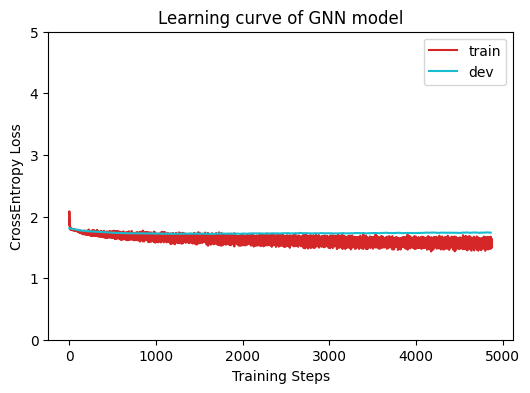

Accuracy = 27.5530%
f1_micro score for each class: [0.20547945 0.50691244 0.0952381  0.27932961 0.20183486 0.24277457]
f1_micro score average: 0.26

2 iteration
Saving model (epoch =    1, loss = 1.8100, accuracy = 17.9537%)
Saving model (epoch =    2, loss = 1.8023, accuracy = 15.2510%)
Saving model (epoch =    3, loss = 1.7998, accuracy = 17.9537%)
Saving model (epoch =    4, loss = 1.7983, accuracy = 16.6023%)
Saving model (epoch =    5, loss = 1.7978, accuracy = 17.1815%)
Saving model (epoch =    6, loss = 1.7956, accuracy = 17.3745%)
Saving model (epoch =    7, loss = 1.7925, accuracy = 17.1815%)
Saving model (epoch =    8, loss = 1.7895, accuracy = 17.5676%)
Saving model (epoch =    9, loss = 1.7851, accuracy = 17.7606%)
Saving model (epoch =   10, loss = 1.7822, accuracy = 17.9537%)
Saving model (epoch =   11, loss = 1.7780, accuracy = 18.3398%)
Saving model (epoch =   12, loss = 1.7734, accuracy = 19.4981%)
Saving model (epoch =   13, loss = 1.7687, accuracy = 20.8494%)
Saving 

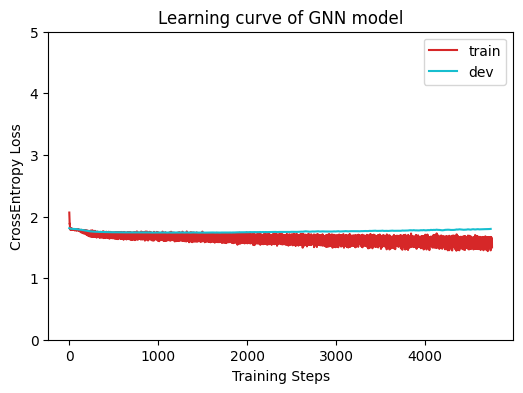

Accuracy = 26.5896%
f1_micro score for each class: [0.25698324 0.39647577 0.20338983 0.11881188 0.21359223 0.28985507]
f1_micro score average: 0.25

3 iteration
Saving model (epoch =    1, loss = 1.8189, accuracy = 17.3410%)
Saving model (epoch =    2, loss = 1.8176, accuracy = 16.9557%)
Saving model (epoch =    3, loss = 1.8093, accuracy = 16.9557%)
Saving model (epoch =    4, loss = 1.8047, accuracy = 17.1484%)
Saving model (epoch =    5, loss = 1.8003, accuracy = 17.9191%)
Saving model (epoch =    6, loss = 1.7924, accuracy = 19.4605%)
Saving model (epoch =    7, loss = 1.7867, accuracy = 21.1946%)
Saving model (epoch =    8, loss = 1.7787, accuracy = 21.3873%)
Saving model (epoch =    9, loss = 1.7709, accuracy = 23.1214%)
Saving model (epoch =   10, loss = 1.7622, accuracy = 23.6994%)
Saving model (epoch =   11, loss = 1.7560, accuracy = 24.8555%)
Saving model (epoch =   12, loss = 1.7481, accuracy = 24.6628%)
Saving model (epoch =   13, loss = 1.7457, accuracy = 25.0482%)
Saving 

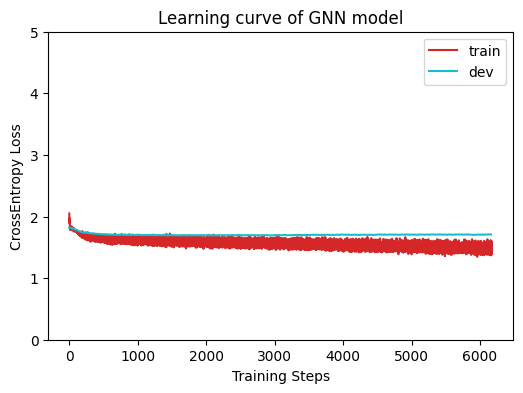

Accuracy = 31.0212%
f1_micro score for each class: [0.16326531 0.52040816 0.26356589 0.28571429 0.26732673 0.30769231]
f1_micro score average: 0.30

4 iteration
Saving model (epoch =    1, loss = 1.8203, accuracy = 15.9923%)
Saving model (epoch =    2, loss = 1.8141, accuracy = 18.6898%)
Saving model (epoch =    3, loss = 1.8075, accuracy = 16.9557%)
Saving model (epoch =    4, loss = 1.8040, accuracy = 17.9191%)
Saving model (epoch =    5, loss = 1.8018, accuracy = 17.3410%)
Saving model (epoch =    6, loss = 1.7989, accuracy = 17.7264%)
Saving model (epoch =    7, loss = 1.7965, accuracy = 18.6898%)
Saving model (epoch =    8, loss = 1.7938, accuracy = 19.2678%)
Saving model (epoch =    9, loss = 1.7918, accuracy = 18.8825%)
Saving model (epoch =   10, loss = 1.7889, accuracy = 19.8459%)
Saving model (epoch =   11, loss = 1.7855, accuracy = 20.2312%)
Saving model (epoch =   12, loss = 1.7831, accuracy = 22.5434%)
Saving model (epoch =   13, loss = 1.7818, accuracy = 23.3141%)
Saving 

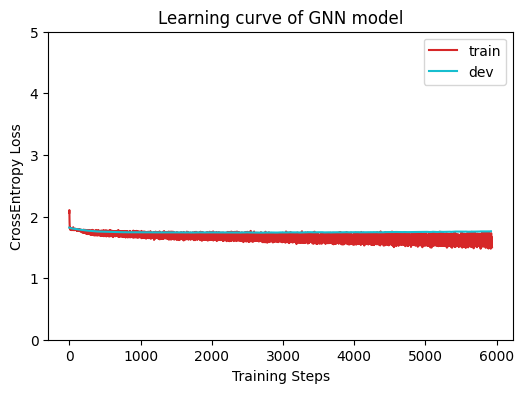

Accuracy = 23.3141%
f1_micro score for each class: [0.12676056 0.33653846 0.19230769 0.17708333 0.23622047 0.28169014]
f1_micro score average: 0.23

5 iteration
Saving model (epoch =    1, loss = 1.8131, accuracy = 18.3398%)
Saving model (epoch =    2, loss = 1.8100, accuracy = 16.9884%)
Saving model (epoch =    3, loss = 1.8049, accuracy = 18.1467%)
Saving model (epoch =    4, loss = 1.8012, accuracy = 18.3398%)
Saving model (epoch =    5, loss = 1.7991, accuracy = 18.7259%)
Saving model (epoch =    6, loss = 1.7950, accuracy = 19.4981%)
Saving model (epoch =    7, loss = 1.7898, accuracy = 20.0772%)
Saving model (epoch =    8, loss = 1.7851, accuracy = 21.8147%)
Saving model (epoch =    9, loss = 1.7791, accuracy = 22.5869%)
Saving model (epoch =   10, loss = 1.7729, accuracy = 24.9035%)
Saving model (epoch =   11, loss = 1.7651, accuracy = 25.8687%)
Saving model (epoch =   12, loss = 1.7572, accuracy = 25.8687%)
Saving model (epoch =   13, loss = 1.7495, accuracy = 26.2548%)
Saving 

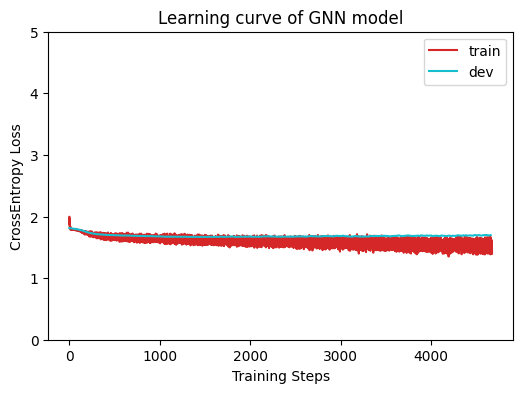

Accuracy = 25.8189%
f1_micro score for each class: [0.21176471 0.40569395 0.01834862 0.18032787 0.26923077 0.25675676]
f1_micro score average: 0.22

6 iteration
Saving model (epoch =    1, loss = 1.7991, accuracy = 18.1118%)
Saving model (epoch =    2, loss = 1.7917, accuracy = 18.4971%)
Saving model (epoch =    3, loss = 1.7848, accuracy = 18.4971%)
Saving model (epoch =    4, loss = 1.7745, accuracy = 20.4239%)
Saving model (epoch =    5, loss = 1.7657, accuracy = 21.5800%)
Saving model (epoch =    6, loss = 1.7520, accuracy = 23.1214%)
Saving model (epoch =    7, loss = 1.7407, accuracy = 23.6994%)
Saving model (epoch =    8, loss = 1.7281, accuracy = 24.4701%)
Saving model (epoch =    9, loss = 1.7179, accuracy = 23.8921%)
Saving model (epoch =   10, loss = 1.7104, accuracy = 24.0848%)
Saving model (epoch =   11, loss = 1.7047, accuracy = 24.8555%)
Saving model (epoch =   12, loss = 1.7012, accuracy = 24.2775%)
Saving model (epoch =   13, loss = 1.6968, accuracy = 24.6628%)
Saving 

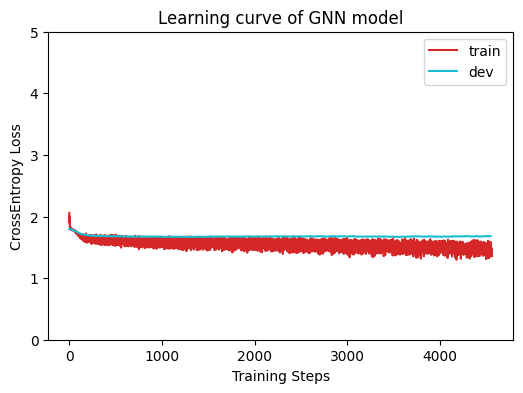

Accuracy = 28.1310%
f1_micro score for each class: [0.26086957 0.57142857 0.04210526 0.18320611 0.25680934 0.26666667]
f1_micro score average: 0.26

7 iteration
Saving model (epoch =    1, loss = 1.8119, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.8008, accuracy = 17.9191%)
Saving model (epoch =    3, loss = 1.7926, accuracy = 19.2678%)
Saving model (epoch =    4, loss = 1.7828, accuracy = 20.8092%)
Saving model (epoch =    5, loss = 1.7749, accuracy = 21.9653%)
Saving model (epoch =    6, loss = 1.7650, accuracy = 23.8921%)
Saving model (epoch =    7, loss = 1.7540, accuracy = 25.8189%)
Saving model (epoch =    8, loss = 1.7409, accuracy = 26.0116%)
Saving model (epoch =    9, loss = 1.7326, accuracy = 26.5896%)
Saving model (epoch =   10, loss = 1.7228, accuracy = 27.5530%)
Saving model (epoch =   11, loss = 1.7156, accuracy = 27.7457%)
Saving model (epoch =   12, loss = 1.7086, accuracy = 28.9017%)
Saving model (epoch =   13, loss = 1.7036, accuracy = 28.7091%)
Saving 

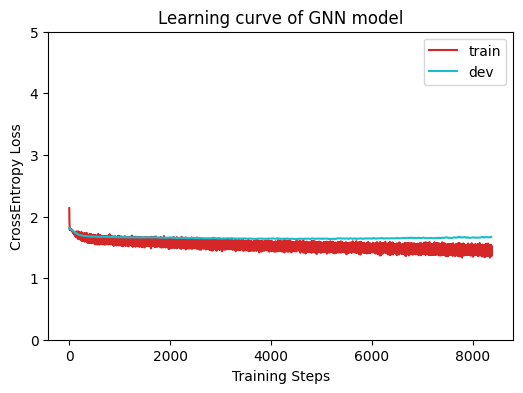

Accuracy = 30.0578%
f1_micro score for each class: [0.23188406 0.47161572 0.27941176 0.20512821 0.30967742 0.2371134 ]
f1_micro score average: 0.29

8 iteration
Saving model (epoch =    1, loss = 1.8297, accuracy = 14.6718%)
Saving model (epoch =    2, loss = 1.8118, accuracy = 15.2510%)
Saving model (epoch =    3, loss = 1.8118, accuracy = 14.8649%)
Saving model (epoch =    4, loss = 1.8097, accuracy = 15.2510%)
Saving model (epoch =    5, loss = 1.8081, accuracy = 15.6371%)
Saving model (epoch =    6, loss = 1.8060, accuracy = 15.8301%)
Saving model (epoch =    7, loss = 1.8041, accuracy = 16.4093%)
Saving model (epoch =    8, loss = 1.8007, accuracy = 15.6371%)
Saving model (epoch =    9, loss = 1.7972, accuracy = 16.0232%)
Saving model (epoch =   10, loss = 1.7952, accuracy = 16.9884%)
Saving model (epoch =   11, loss = 1.7927, accuracy = 18.1467%)
Saving model (epoch =   12, loss = 1.7904, accuracy = 17.9537%)
Saving model (epoch =   13, loss = 1.7874, accuracy = 18.9189%)
Saving 

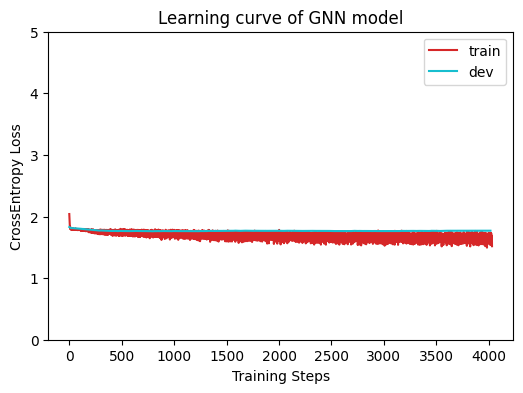

Accuracy = 25.6262%
f1_micro score for each class: [0.09345794 0.38961039 0.15652174 0.22727273 0.3125     0.20540541]
f1_micro score average: 0.23

9 iteration
Saving model (epoch =    1, loss = 1.8170, accuracy = 16.7954%)
Saving model (epoch =    2, loss = 1.8085, accuracy = 16.2162%)
Saving model (epoch =    3, loss = 1.8070, accuracy = 16.9884%)
Saving model (epoch =    4, loss = 1.8040, accuracy = 17.3745%)
Saving model (epoch =    5, loss = 1.7990, accuracy = 16.4093%)
Saving model (epoch =    6, loss = 1.7940, accuracy = 17.3745%)
Saving model (epoch =    7, loss = 1.7866, accuracy = 19.6911%)
Saving model (epoch =    8, loss = 1.7738, accuracy = 23.9382%)
Saving model (epoch =    9, loss = 1.7600, accuracy = 26.0618%)
Saving model (epoch =   10, loss = 1.7434, accuracy = 28.9575%)
Saving model (epoch =   11, loss = 1.7316, accuracy = 28.5714%)
Saving model (epoch =   12, loss = 1.7193, accuracy = 29.1506%)
Saving model (epoch =   13, loss = 1.7096, accuracy = 30.1158%)
Saving 

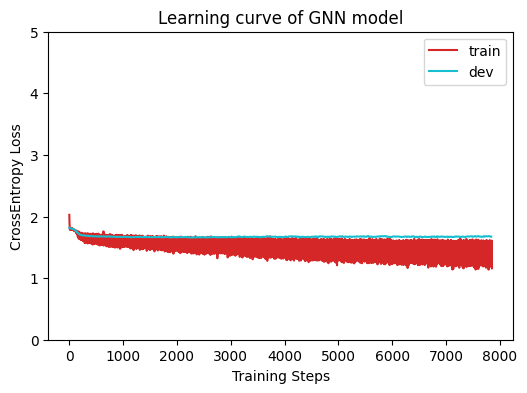

Accuracy = 27.5530%
f1_micro score for each class: [0.06722689 0.5497076  0.09345794 0.16528926 0.28828829 0.30201342]
f1_micro score average: 0.24

10 iteration
Saving model (epoch =    1, loss = 1.8279, accuracy = 16.4093%)
Saving model (epoch =    2, loss = 1.8186, accuracy = 16.9884%)
Saving model (epoch =    3, loss = 1.8126, accuracy = 16.6023%)
Saving model (epoch =    4, loss = 1.8124, accuracy = 16.2162%)
Saving model (epoch =    5, loss = 1.8124, accuracy = 16.9884%)
Saving model (epoch =    6, loss = 1.8099, accuracy = 17.1815%)
Saving model (epoch =    7, loss = 1.8076, accuracy = 17.5676%)
Saving model (epoch =    8, loss = 1.8072, accuracy = 17.1815%)
Saving model (epoch =    9, loss = 1.8054, accuracy = 16.9884%)
Saving model (epoch =   10, loss = 1.8025, accuracy = 17.7606%)
Saving model (epoch =   11, loss = 1.7998, accuracy = 18.3398%)
Saving model (epoch =   12, loss = 1.7990, accuracy = 17.3745%)
Saving model (epoch =   13, loss = 1.7956, accuracy = 18.3398%)
Saving

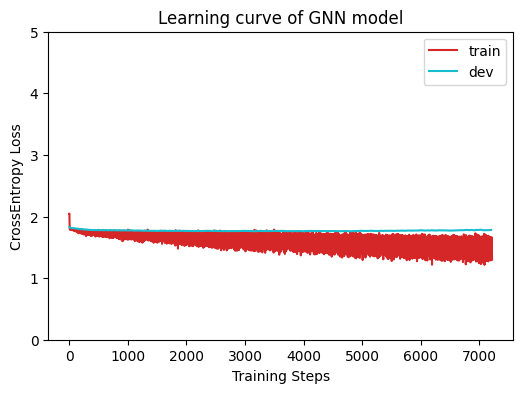

Accuracy = 23.8921%
f1_micro score for each class: [0.24390244 0.4        0.20242915 0.21656051 0.19631902 0.14754098]
f1_micro score average: 0.23
Final accuracy for each dataset: [0.27552986512524086, 0.2658959537572254, 0.31021194605009633, 0.23314065510597304, 0.2581888246628131, 0.2813102119460501, 0.30057803468208094, 0.25626204238921, 0.27552986512524086, 0.23892100192678228]
Average accuracy: 26.9557%


In [ ]:
Model = GAT
hparas = {}
average_test(Model, hparas, data_config, config, device, myseed)

## **Save Training Log**
Save the model structure, config and result, and append to the log.txt

In [ ]:
training_log.save_result(data_config, config)

# **Report Result**
**Please DO NOT delete the output result**

## **KNN with different method**

### **Pearson**

#### **k = 3**

GCN(
  (initial_conv): GCNConv(24, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  14854

1 iteration
Saving model (epoch =    1, loss = 1.7871, accuracy = 19.2678%)
Saving model (epoch =    2, loss = 1.7791, accuracy = 23.1214%)
Saving model (epoch =    3, loss = 1.7699, accuracy = 26.2042%)
Saving model (epoch =    4, loss = 1.7585, accuracy = 26.2042%)
Saving model (epoch =    5, loss = 1.7460, accuracy = 27.3603%)
Saving model (epoch =    6, loss = 1.7369, accuracy = 27.1676%)
Saving model (epoch =    7, loss = 1.7323, accuracy = 27.3603%)
Saving model (epoch =    8, loss = 1.7302, accuracy = 27.9383%)
Saving model (epoch =    9, loss = 1.7279, accuracy = 27.9383%)
Saving model (epoch =   10, loss = 1.7251, accuracy = 28.1310%)
Saving model (epoch =   11, loss = 1.7223, accuracy = 27.9383%)
Saving model (epoch =   12, loss = 1.7

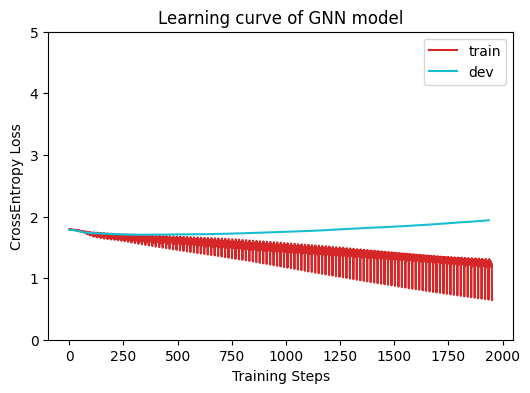

Accuracy = 28.1310%
f1_micro score for each class: [0.23255814 0.5        0.21917808 0.24590164 0.13924051 0.24      ]
f1_micro score average: 0.26

2 iteration
Saving model (epoch =    1, loss = 1.7919, accuracy = 15.8301%)
Saving model (epoch =    3, loss = 1.7897, accuracy = 15.2510%)
Saving model (epoch =    4, loss = 1.7825, accuracy = 19.8842%)
Saving model (epoch =    5, loss = 1.7703, accuracy = 22.2008%)
Saving model (epoch =    6, loss = 1.7589, accuracy = 24.1313%)
Saving model (epoch =    7, loss = 1.7516, accuracy = 24.9035%)
Saving model (epoch =    8, loss = 1.7472, accuracy = 24.5174%)
Saving model (epoch =    9, loss = 1.7443, accuracy = 22.9730%)
Saving model (epoch =   10, loss = 1.7418, accuracy = 23.1660%)
Saving model (epoch =   11, loss = 1.7381, accuracy = 24.3243%)
Saving model (epoch =   12, loss = 1.7349, accuracy = 25.4826%)
Saving model (epoch =   13, loss = 1.7312, accuracy = 25.6757%)
Saving model (epoch =   14, loss = 1.7280, accuracy = 25.8687%)
Saving 

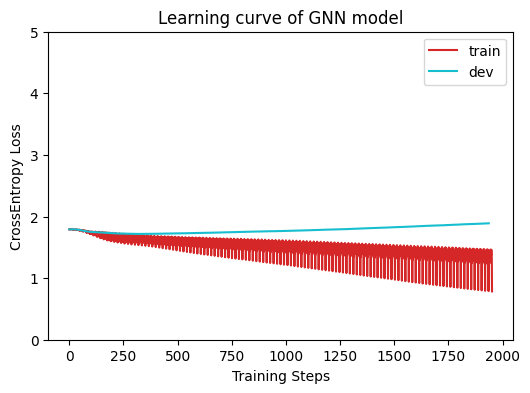

Accuracy = 28.5164%
f1_micro score for each class: [0.24324324 0.46666667 0.21590909 0.29473684 0.11570248 0.30493274]
f1_micro score average: 0.27

3 iteration
Saving model (epoch =    1, loss = 1.7899, accuracy = 19.8459%)
Saving model (epoch =    2, loss = 1.7847, accuracy = 22.3507%)
Saving model (epoch =    3, loss = 1.7760, accuracy = 22.5434%)
Saving model (epoch =    4, loss = 1.7626, accuracy = 24.8555%)
Saving model (epoch =    5, loss = 1.7455, accuracy = 25.8189%)
Saving model (epoch =    6, loss = 1.7268, accuracy = 26.7823%)
Saving model (epoch =    7, loss = 1.7099, accuracy = 28.3237%)
Saving model (epoch =    8, loss = 1.6966, accuracy = 27.5530%)
Saving model (epoch =    9, loss = 1.6872, accuracy = 26.5896%)
Saving model (epoch =   10, loss = 1.6808, accuracy = 27.1676%)
Saving model (epoch =   11, loss = 1.6765, accuracy = 27.1676%)
Saving model (epoch =   12, loss = 1.6732, accuracy = 27.3603%)
Saving model (epoch =   13, loss = 1.6708, accuracy = 28.1310%)
Saving 

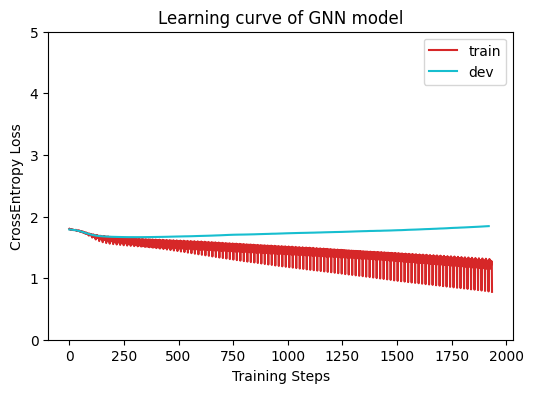

Accuracy = 31.2139%
f1_micro score for each class: [0.23030303 0.53271028 0.3190184  0.21212121 0.24705882 0.25773196]
f1_micro score average: 0.30

4 iteration
Saving model (epoch =    1, loss = 1.7916, accuracy = 16.3776%)
Saving model (epoch =    2, loss = 1.7886, accuracy = 19.6532%)
Saving model (epoch =    3, loss = 1.7834, accuracy = 20.2312%)
Saving model (epoch =    4, loss = 1.7748, accuracy = 22.5434%)
Saving model (epoch =    5, loss = 1.7630, accuracy = 23.3141%)
Saving model (epoch =    6, loss = 1.7505, accuracy = 23.8921%)
Saving model (epoch =    7, loss = 1.7405, accuracy = 24.8555%)
Saving model (epoch =    8, loss = 1.7326, accuracy = 24.4701%)
Saving model (epoch =    9, loss = 1.7266, accuracy = 24.8555%)
Saving model (epoch =   10, loss = 1.7223, accuracy = 25.0482%)
Saving model (epoch =   11, loss = 1.7180, accuracy = 26.0116%)
Saving model (epoch =   12, loss = 1.7142, accuracy = 27.3603%)
Saving model (epoch =   13, loss = 1.7120, accuracy = 27.1676%)
Saving 

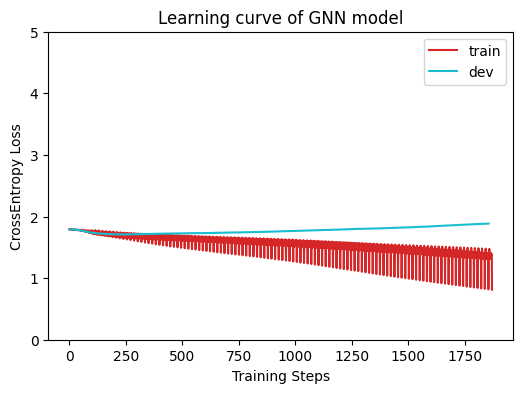

Accuracy = 26.0116%
f1_micro score for each class: [0.16883117 0.37788018 0.26595745 0.24390244 0.11965812 0.29292929]
f1_micro score average: 0.24

5 iteration
Saving model (epoch =    1, loss = 1.7920, accuracy = 15.6371%)
Saving model (epoch =    2, loss = 1.7885, accuracy = 18.1467%)
Saving model (epoch =    3, loss = 1.7869, accuracy = 18.7259%)
Saving model (epoch =    4, loss = 1.7822, accuracy = 19.1120%)
Saving model (epoch =    5, loss = 1.7732, accuracy = 23.5521%)
Saving model (epoch =    6, loss = 1.7607, accuracy = 25.4826%)
Saving model (epoch =    7, loss = 1.7450, accuracy = 26.6409%)
Saving model (epoch =    8, loss = 1.7292, accuracy = 27.6062%)
Saving model (epoch =    9, loss = 1.7168, accuracy = 27.0270%)
Saving model (epoch =   10, loss = 1.7079, accuracy = 27.0270%)
Saving model (epoch =   11, loss = 1.7034, accuracy = 27.2201%)
Saving model (epoch =   12, loss = 1.7010, accuracy = 26.4479%)
Saving model (epoch =   13, loss = 1.6992, accuracy = 27.0270%)
Saving 

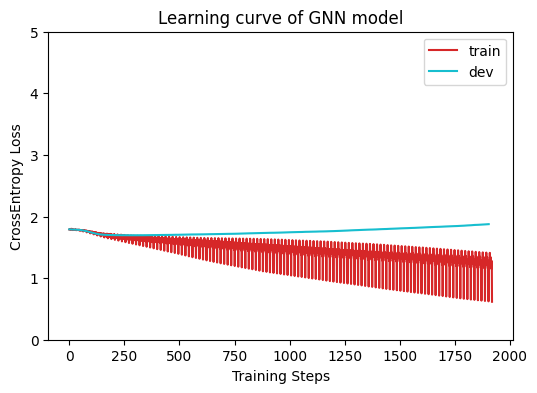

Accuracy = 25.2408%
f1_micro score for each class: [0.22916667 0.3923445  0.12307692 0.20645161 0.29166667 0.2       ]
f1_micro score average: 0.24

6 iteration
Saving model (epoch =    1, loss = 1.7896, accuracy = 20.6166%)
Saving model (epoch =    2, loss = 1.7826, accuracy = 20.0385%)
Saving model (epoch =    3, loss = 1.7673, accuracy = 22.5434%)
Saving model (epoch =    4, loss = 1.7471, accuracy = 22.9287%)
Saving model (epoch =    5, loss = 1.7283, accuracy = 24.2775%)
Saving model (epoch =    6, loss = 1.7177, accuracy = 24.6628%)
Saving model (epoch =    7, loss = 1.7122, accuracy = 24.2775%)
Saving model (epoch =    8, loss = 1.7099, accuracy = 24.4701%)
Saving model (epoch =    9, loss = 1.7078, accuracy = 25.0482%)
Saving model (epoch =   10, loss = 1.7051, accuracy = 25.8189%)
Saving model (epoch =   11, loss = 1.7026, accuracy = 26.3969%)
Saving model (epoch =   12, loss = 1.7006, accuracy = 26.2042%)
Saving model (epoch =   13, loss = 1.6985, accuracy = 26.0116%)
Saving 

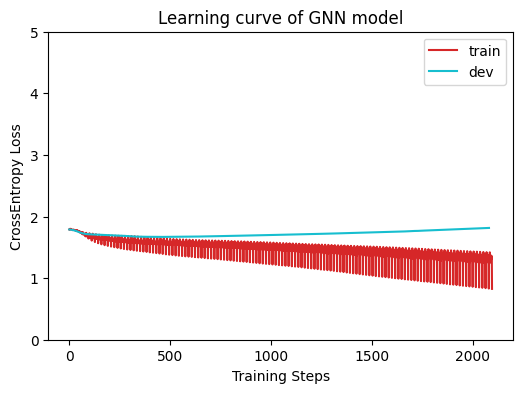

Accuracy = 29.6724%
f1_micro score for each class: [0.20809249 0.52356021 0.33526012 0.27536232 0.19791667 0.22222222]
f1_micro score average: 0.29

7 iteration
Saving model (epoch =    1, loss = 1.7912, accuracy = 18.8825%)
Saving model (epoch =    2, loss = 1.7840, accuracy = 22.1580%)
Saving model (epoch =    3, loss = 1.7708, accuracy = 25.0482%)
Saving model (epoch =    4, loss = 1.7479, accuracy = 26.9750%)
Saving model (epoch =    5, loss = 1.7217, accuracy = 28.3237%)
Saving model (epoch =    6, loss = 1.6986, accuracy = 30.0578%)
Saving model (epoch =    7, loss = 1.6805, accuracy = 29.0944%)
Saving model (epoch =    8, loss = 1.6671, accuracy = 29.2871%)
Saving model (epoch =    9, loss = 1.6588, accuracy = 30.0578%)
Saving model (epoch =   10, loss = 1.6529, accuracy = 29.2871%)
Saving model (epoch =   11, loss = 1.6494, accuracy = 30.0578%)
Saving model (epoch =   12, loss = 1.6465, accuracy = 29.4798%)
Saving model (epoch =   13, loss = 1.6442, accuracy = 29.4798%)
Saving 

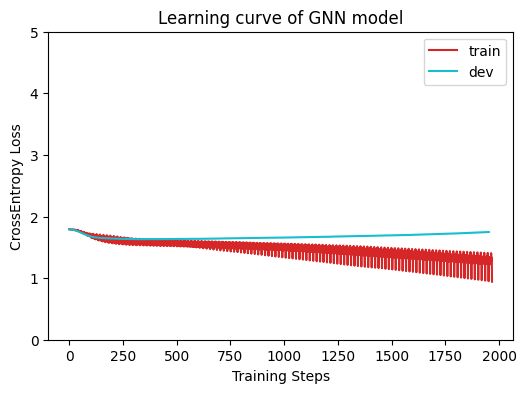

Accuracy = 34.6821%
f1_micro score for each class: [0.27380952 0.46829268 0.35532995 0.4040404  0.34177215 0.125     ]
f1_micro score average: 0.33

8 iteration
Saving model (epoch =    1, loss = 1.7951, accuracy = 15.8301%)
Saving model (epoch =    2, loss = 1.7936, accuracy = 14.6718%)
Saving model (epoch =    3, loss = 1.7926, accuracy = 15.6371%)
Saving model (epoch =    4, loss = 1.7913, accuracy = 16.9884%)
Saving model (epoch =    5, loss = 1.7892, accuracy = 18.1467%)
Saving model (epoch =    6, loss = 1.7863, accuracy = 19.1120%)
Saving model (epoch =    7, loss = 1.7827, accuracy = 20.8494%)
Saving model (epoch =    8, loss = 1.7792, accuracy = 21.4286%)
Saving model (epoch =    9, loss = 1.7761, accuracy = 22.3938%)
Saving model (epoch =   10, loss = 1.7740, accuracy = 22.7799%)
Saving model (epoch =   11, loss = 1.7722, accuracy = 23.1660%)
Saving model (epoch =   12, loss = 1.7702, accuracy = 22.9730%)
Saving model (epoch =   13, loss = 1.7685, accuracy = 22.7799%)
Saving 

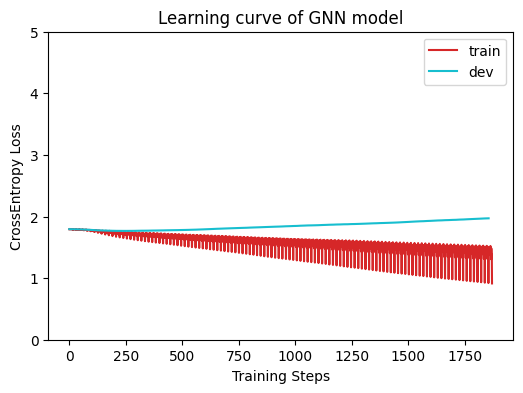

Accuracy = 25.8189%
f1_micro score for each class: [0.22222222 0.37037037 0.26744186 0.24338624 0.10526316 0.16666667]
f1_micro score average: 0.23

9 iteration
Saving model (epoch =    1, loss = 1.7891, accuracy = 19.1120%)
Saving model (epoch =    2, loss = 1.7835, accuracy = 24.9035%)
Saving model (epoch =    3, loss = 1.7703, accuracy = 26.6409%)
Saving model (epoch =    4, loss = 1.7452, accuracy = 30.3089%)
Saving model (epoch =    5, loss = 1.7115, accuracy = 29.1506%)
Saving model (epoch =    6, loss = 1.6826, accuracy = 30.5019%)
Saving model (epoch =    7, loss = 1.6633, accuracy = 30.8880%)
Saving model (epoch =    8, loss = 1.6497, accuracy = 31.0811%)
Saving model (epoch =    9, loss = 1.6426, accuracy = 30.6950%)
Saving model (epoch =   10, loss = 1.6394, accuracy = 30.8880%)
Saving model (epoch =   11, loss = 1.6389, accuracy = 31.0811%)
Saving model (epoch =   13, loss = 1.6388, accuracy = 31.2741%)
Saving model (epoch =   14, loss = 1.6375, accuracy = 31.2741%)
Saving 

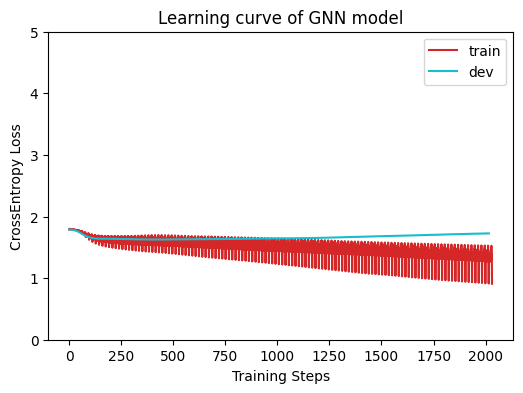

Accuracy = 32.7553%
f1_micro score for each class: [0.22695035 0.48044693 0.20645161 0.44347826 0.2459893  0.28767123]
f1_micro score average: 0.32

10 iteration
Saving model (epoch =    1, loss = 1.7894, accuracy = 20.8494%)
Saving model (epoch =    2, loss = 1.7894, accuracy = 18.7259%)
Saving model (epoch =    3, loss = 1.7887, accuracy = 18.7259%)
Saving model (epoch =    4, loss = 1.7879, accuracy = 19.6911%)
Saving model (epoch =    5, loss = 1.7868, accuracy = 20.8494%)
Saving model (epoch =    6, loss = 1.7853, accuracy = 21.6216%)
Saving model (epoch =    7, loss = 1.7839, accuracy = 21.6216%)
Saving model (epoch =    8, loss = 1.7823, accuracy = 22.7799%)
Saving model (epoch =    9, loss = 1.7813, accuracy = 21.6216%)
Finished training after 110 epochs


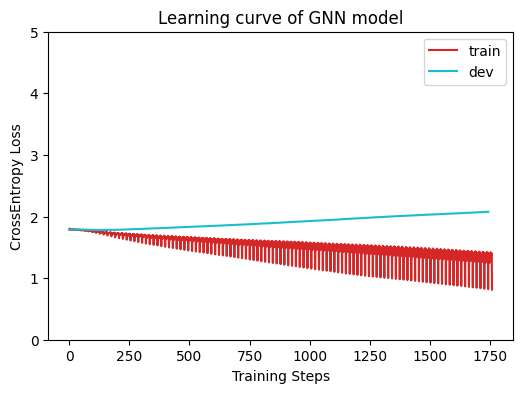

Accuracy = 18.1118%
f1_micro score for each class: [0.23364486 0.28       0.11188811 0.09876543 0.1589404  0.10169492]
f1_micro score average: 0.16
Final accuracy for each dataset: [0.2813102119460501, 0.28516377649325625, 0.31213872832369943, 0.26011560693641617, 0.2524084778420039, 0.29672447013487474, 0.3468208092485549, 0.2581888246628131, 0.32755298651252407, 0.1811175337186898]
Average accuracy: 28.0154%


In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

GAT(
  (initial_conv): GATv2Conv(32, 3, heads=8)
  (conv1): GATv2Conv(24, 3, heads=8)
  (conv2): GATv2Conv(24, 3, heads=8)
  (conv3): GATv2Conv(24, 3, heads=8)
  (set2set): Set2Set(24, 48)
  (sagpool): SAGPooling(GATv2Conv, 24, ratio=0.75, multiplier=1.0)
  (out): Linear(in_features=48, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  12827

1 iteration
Saving model (epoch =    1, loss = 1.8031, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.7995, accuracy = 19.4605%)
Saving model (epoch =    3, loss = 1.7930, accuracy = 18.8825%)
Saving model (epoch =    4, loss = 1.7905, accuracy = 19.0751%)
Saving model (epoch =    5, loss = 1.7864, accuracy = 19.4605%)
Saving model (epoch =    6, loss = 1.7821, accuracy = 21.5800%)
Saving model (epoch =    7, loss = 1.7776, accuracy = 22.5434%)
Saving model (epoch =    8, loss = 1.7733, accuracy = 23.5067%)
Saving model (epoch =    9, loss = 1.7689, accuracy = 23.6994%)
Saving model (epoch =   10, los

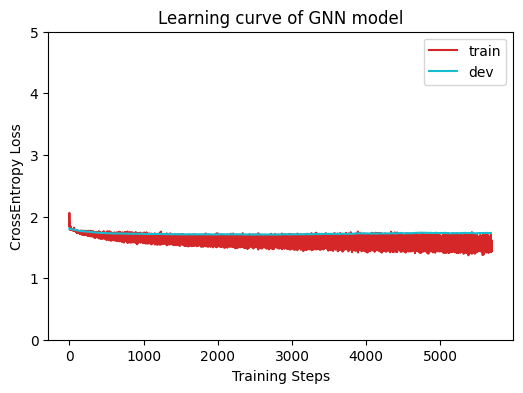

Accuracy = 29.2871%
f1_micro score for each class: [0.29239766 0.43881857 0.24806202 0.26490066 0.17834395 0.25906736]
f1_micro score average: 0.28

2 iteration
Saving model (epoch =    1, loss = 1.8085, accuracy = 17.9537%)
Saving model (epoch =    2, loss = 1.7991, accuracy = 17.1815%)
Saving model (epoch =    3, loss = 1.7984, accuracy = 17.3745%)
Saving model (epoch =    4, loss = 1.7959, accuracy = 16.9884%)
Saving model (epoch =    5, loss = 1.7946, accuracy = 16.7954%)
Saving model (epoch =    6, loss = 1.7924, accuracy = 17.5676%)
Saving model (epoch =    7, loss = 1.7884, accuracy = 17.5676%)
Saving model (epoch =    8, loss = 1.7831, accuracy = 18.7259%)
Saving model (epoch =    9, loss = 1.7762, accuracy = 18.9189%)
Saving model (epoch =   10, loss = 1.7696, accuracy = 22.2008%)
Saving model (epoch =   11, loss = 1.7625, accuracy = 22.5869%)
Saving model (epoch =   12, loss = 1.7561, accuracy = 24.5174%)
Saving model (epoch =   13, loss = 1.7500, accuracy = 24.7104%)
Saving 

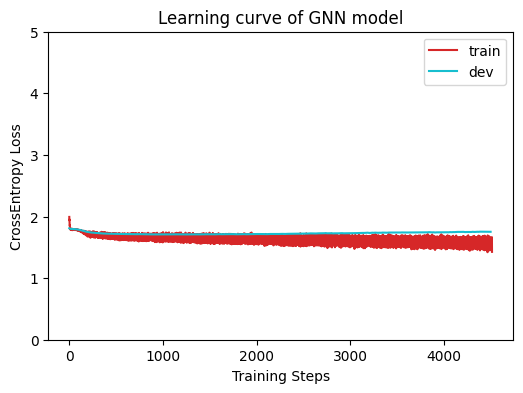

Accuracy = 28.7091%
f1_micro score for each class: [0.20731707 0.45849802 0.15       0.33766234 0.20809249 0.24137931]
f1_micro score average: 0.27

3 iteration
Saving model (epoch =    1, loss = 1.8106, accuracy = 16.9557%)
Saving model (epoch =    2, loss = 1.8101, accuracy = 17.3410%)
Saving model (epoch =    3, loss = 1.8038, accuracy = 17.5337%)
Saving model (epoch =    4, loss = 1.8007, accuracy = 17.7264%)
Saving model (epoch =    5, loss = 1.7979, accuracy = 18.4971%)
Saving model (epoch =    6, loss = 1.7937, accuracy = 18.6898%)
Saving model (epoch =    7, loss = 1.7896, accuracy = 19.0751%)
Saving model (epoch =    8, loss = 1.7845, accuracy = 18.6898%)
Saving model (epoch =    9, loss = 1.7788, accuracy = 19.6532%)
Saving model (epoch =   10, loss = 1.7735, accuracy = 19.6532%)
Saving model (epoch =   11, loss = 1.7665, accuracy = 20.2312%)
Saving model (epoch =   12, loss = 1.7612, accuracy = 21.1946%)
Saving model (epoch =   13, loss = 1.7561, accuracy = 22.1580%)
Saving 

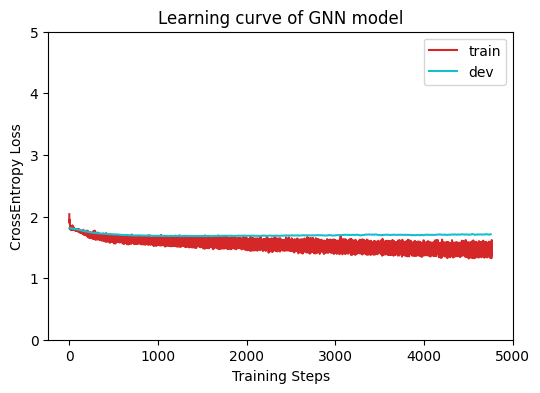

Accuracy = 30.2505%
f1_micro score for each class: [0.2320442  0.51612903 0.224      0.25174825 0.27979275 0.23463687]
f1_micro score average: 0.29

4 iteration
Saving model (epoch =    1, loss = 1.8194, accuracy = 15.6069%)
Saving model (epoch =    2, loss = 1.8136, accuracy = 16.9557%)
Saving model (epoch =    3, loss = 1.8044, accuracy = 15.6069%)
Saving model (epoch =    4, loss = 1.7988, accuracy = 16.9557%)
Saving model (epoch =    5, loss = 1.7966, accuracy = 17.5337%)
Saving model (epoch =    6, loss = 1.7940, accuracy = 18.1118%)
Saving model (epoch =    7, loss = 1.7914, accuracy = 18.4971%)
Saving model (epoch =    8, loss = 1.7879, accuracy = 19.4605%)
Saving model (epoch =    9, loss = 1.7863, accuracy = 19.2678%)
Saving model (epoch =   10, loss = 1.7826, accuracy = 20.8092%)
Saving model (epoch =   11, loss = 1.7807, accuracy = 20.8092%)
Saving model (epoch =   12, loss = 1.7778, accuracy = 20.4239%)
Saving model (epoch =   13, loss = 1.7750, accuracy = 21.1946%)
Saving 

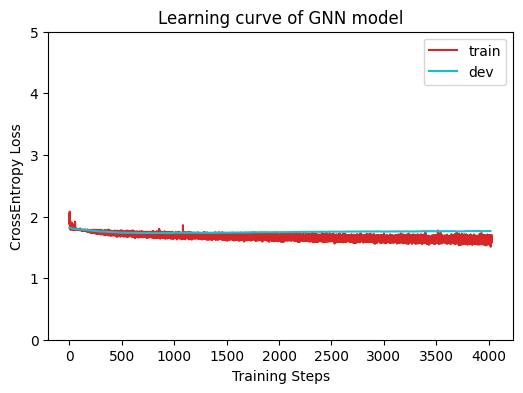

Accuracy = 24.2775%
f1_micro score for each class: [0.12598425 0.36909871 0.21390374 0.21118012 0.24742268 0.20588235]
f1_micro score average: 0.23

5 iteration
Saving model (epoch =    1, loss = 1.8084, accuracy = 18.3398%)
Saving model (epoch =    2, loss = 1.8059, accuracy = 16.2162%)
Saving model (epoch =    3, loss = 1.8022, accuracy = 18.5328%)
Saving model (epoch =    4, loss = 1.8004, accuracy = 18.7259%)
Saving model (epoch =    5, loss = 1.7999, accuracy = 18.7259%)
Saving model (epoch =    6, loss = 1.7959, accuracy = 18.9189%)
Saving model (epoch =    7, loss = 1.7935, accuracy = 18.5328%)
Saving model (epoch =    8, loss = 1.7898, accuracy = 19.4981%)
Saving model (epoch =    9, loss = 1.7855, accuracy = 22.2008%)
Saving model (epoch =   10, loss = 1.7798, accuracy = 23.3591%)
Saving model (epoch =   11, loss = 1.7743, accuracy = 24.5174%)
Saving model (epoch =   12, loss = 1.7677, accuracy = 27.2201%)
Saving model (epoch =   13, loss = 1.7610, accuracy = 26.2548%)
Saving 

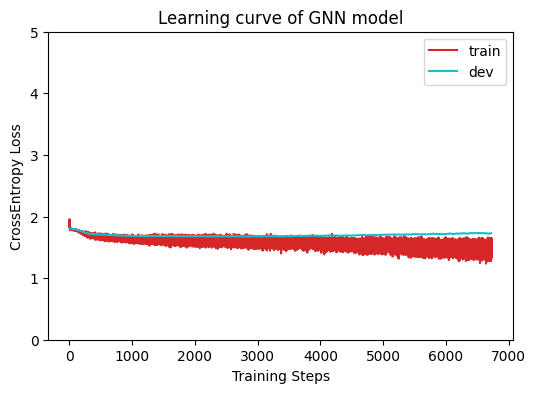

Accuracy = 28.1310%
f1_micro score for each class: [0.28985507 0.44444444 0.096      0.208      0.28888889 0.26600985]
f1_micro score average: 0.27

6 iteration
Saving model (epoch =    1, loss = 1.7980, accuracy = 18.3044%)
Saving model (epoch =    2, loss = 1.7911, accuracy = 19.2678%)
Saving model (epoch =    3, loss = 1.7876, accuracy = 18.4971%)
Saving model (epoch =    4, loss = 1.7809, accuracy = 19.0751%)
Saving model (epoch =    5, loss = 1.7749, accuracy = 21.0019%)
Saving model (epoch =    6, loss = 1.7666, accuracy = 22.5434%)
Saving model (epoch =    7, loss = 1.7565, accuracy = 23.8921%)
Saving model (epoch =    8, loss = 1.7453, accuracy = 23.5067%)
Saving model (epoch =    9, loss = 1.7350, accuracy = 23.6994%)
Saving model (epoch =   10, loss = 1.7275, accuracy = 24.2775%)
Saving model (epoch =   11, loss = 1.7228, accuracy = 24.6628%)
Saving model (epoch =   12, loss = 1.7165, accuracy = 25.2408%)
Saving model (epoch =   13, loss = 1.7131, accuracy = 26.2042%)
Saving 

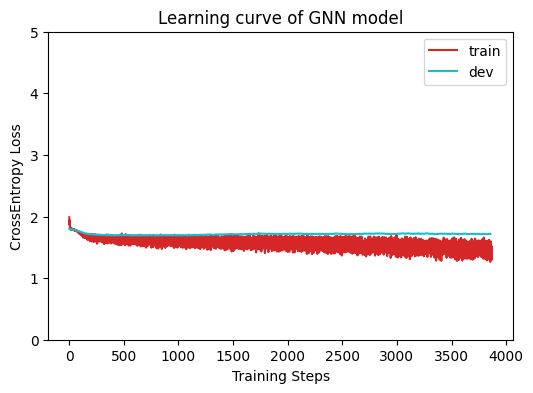

Accuracy = 25.2408%
f1_micro score for each class: [0.11864407 0.58947368 0.11881188 0.13333333 0.26771654 0.03539823]
f1_micro score average: 0.21

7 iteration
Saving model (epoch =    1, loss = 1.8083, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.7968, accuracy = 21.3873%)
Saving model (epoch =    3, loss = 1.7883, accuracy = 20.0385%)
Saving model (epoch =    4, loss = 1.7794, accuracy = 22.1580%)
Saving model (epoch =    5, loss = 1.7719, accuracy = 21.5800%)
Saving model (epoch =    6, loss = 1.7612, accuracy = 23.8921%)
Saving model (epoch =    7, loss = 1.7491, accuracy = 25.8189%)
Saving model (epoch =    8, loss = 1.7368, accuracy = 26.9750%)
Saving model (epoch =    9, loss = 1.7253, accuracy = 28.3237%)
Saving model (epoch =   10, loss = 1.7156, accuracy = 27.7457%)
Saving model (epoch =   11, loss = 1.7070, accuracy = 27.7457%)
Saving model (epoch =   12, loss = 1.6975, accuracy = 29.4798%)
Saving model (epoch =   13, loss = 1.6928, accuracy = 29.2871%)
Saving 

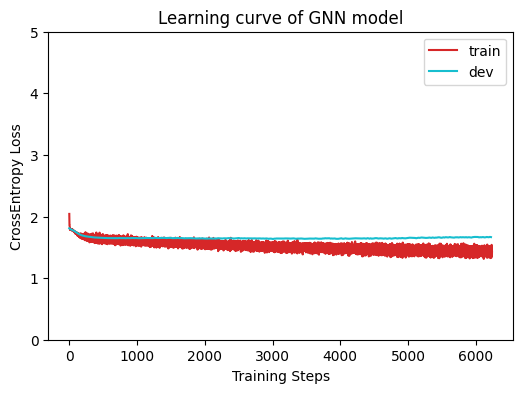

Accuracy = 30.2505%
f1_micro score for each class: [0.28571429 0.4742268  0.23703704 0.25806452 0.2519685  0.26373626]
f1_micro score average: 0.30

8 iteration
Saving model (epoch =    1, loss = 1.8267, accuracy = 14.6718%)
Saving model (epoch =    2, loss = 1.8084, accuracy = 14.8649%)
Saving model (epoch =    5, loss = 1.8066, accuracy = 14.8649%)
Saving model (epoch =    6, loss = 1.8046, accuracy = 14.6718%)
Saving model (epoch =    7, loss = 1.8019, accuracy = 15.2510%)
Saving model (epoch =    8, loss = 1.7992, accuracy = 15.6371%)
Saving model (epoch =    9, loss = 1.7962, accuracy = 16.2162%)
Saving model (epoch =   10, loss = 1.7957, accuracy = 16.9884%)
Saving model (epoch =   11, loss = 1.7914, accuracy = 18.3398%)
Saving model (epoch =   12, loss = 1.7892, accuracy = 18.1467%)
Saving model (epoch =   13, loss = 1.7850, accuracy = 20.0772%)
Saving model (epoch =   14, loss = 1.7820, accuracy = 20.2703%)
Saving model (epoch =   15, loss = 1.7814, accuracy = 19.8842%)
Saving 

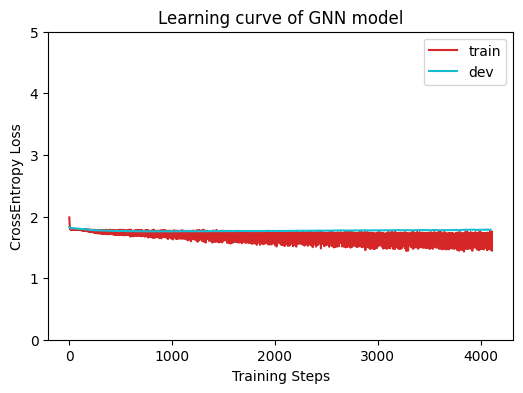

Accuracy = 24.6628%
f1_micro score for each class: [0.09090909 0.37209302 0.09259259 0.18064516 0.2974359  0.25471698]
f1_micro score average: 0.21

9 iteration
Saving model (epoch =    1, loss = 1.8120, accuracy = 16.6023%)
Saving model (epoch =    2, loss = 1.8047, accuracy = 17.7606%)
Saving model (epoch =    3, loss = 1.8032, accuracy = 16.7954%)
Saving model (epoch =    4, loss = 1.8003, accuracy = 16.9884%)
Saving model (epoch =    5, loss = 1.7969, accuracy = 16.9884%)
Saving model (epoch =    6, loss = 1.7934, accuracy = 16.9884%)
Saving model (epoch =    7, loss = 1.7861, accuracy = 18.9189%)
Saving model (epoch =    8, loss = 1.7789, accuracy = 22.2008%)
Saving model (epoch =    9, loss = 1.7674, accuracy = 25.0965%)
Saving model (epoch =   10, loss = 1.7541, accuracy = 26.4479%)
Saving model (epoch =   11, loss = 1.7409, accuracy = 27.7992%)
Saving model (epoch =   12, loss = 1.7290, accuracy = 29.7297%)
Saving model (epoch =   13, loss = 1.7193, accuracy = 29.1506%)
Saving 

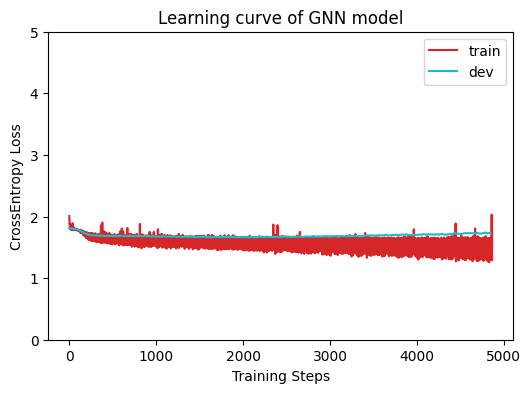

Accuracy = 30.4432%
f1_micro score for each class: [0.07920792 0.51497006 0.10434783 0.32394366 0.35625    0.25906736]
f1_micro score average: 0.27

10 iteration
Saving model (epoch =    1, loss = 1.8224, accuracy = 16.4093%)
Saving model (epoch =    2, loss = 1.8125, accuracy = 15.8301%)
Saving model (epoch =    3, loss = 1.8065, accuracy = 16.6023%)
Saving model (epoch =    4, loss = 1.8060, accuracy = 16.6023%)
Saving model (epoch =    5, loss = 1.8050, accuracy = 17.5676%)
Saving model (epoch =    6, loss = 1.8040, accuracy = 17.7606%)
Saving model (epoch =    7, loss = 1.8017, accuracy = 18.5328%)
Saving model (epoch =    8, loss = 1.7999, accuracy = 19.1120%)
Saving model (epoch =    9, loss = 1.7990, accuracy = 19.3050%)
Saving model (epoch =   10, loss = 1.7987, accuracy = 19.6911%)
Saving model (epoch =   11, loss = 1.7970, accuracy = 19.8842%)
Saving model (epoch =   12, loss = 1.7962, accuracy = 20.2703%)
Saving model (epoch =   13, loss = 1.7939, accuracy = 19.6911%)
Saving

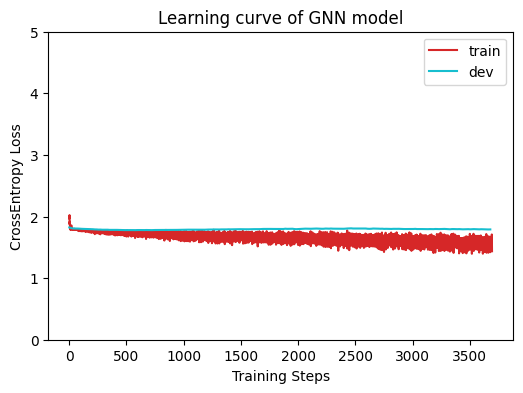

Accuracy = 22.5434%
f1_micro score for each class: [0.13986014 0.36363636 0.08510638 0.23312883 0.24025974 0.14876033]
f1_micro score average: 0.20
Final accuracy for each dataset: [0.2928709055876686, 0.28709055876685935, 0.302504816955684, 0.24277456647398843, 0.2813102119460501, 0.2524084778420039, 0.302504816955684, 0.2466281310211946, 0.3044315992292871, 0.2254335260115607]
Average accuracy: 27.3796%


In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 6**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

GAT(
  (initial_conv): GATv2Conv(32, 3, heads=8)
  (conv1): GATv2Conv(24, 3, heads=8)
  (conv2): GATv2Conv(24, 3, heads=8)
  (conv3): GATv2Conv(24, 3, heads=8)
  (set2set): Set2Set(24, 48)
  (sagpool): SAGPooling(GATv2Conv, 24, ratio=0.75, multiplier=1.0)
  (out): Linear(in_features=48, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  12827

1 iteration
Saving model (epoch =    1, loss = 1.8018, accuracy = 19.0751%)
Saving model (epoch =    2, loss = 1.7944, accuracy = 18.8825%)
Saving model (epoch =    3, loss = 1.7891, accuracy = 19.0751%)
Saving model (epoch =    4, loss = 1.7866, accuracy = 18.4971%)
Saving model (epoch =    5, loss = 1.7837, accuracy = 19.0751%)
Saving model (epoch =    6, loss = 1.7799, accuracy = 20.0385%)
Saving model (epoch =    7, loss = 1.7754, accuracy = 21.7726%)
Saving model (epoch =    8, loss = 1.7702, accuracy = 24.2775%)
Saving model (epoch =    9, loss = 1.7658, accuracy = 24.4701%)
Saving model (epoch =   10, los

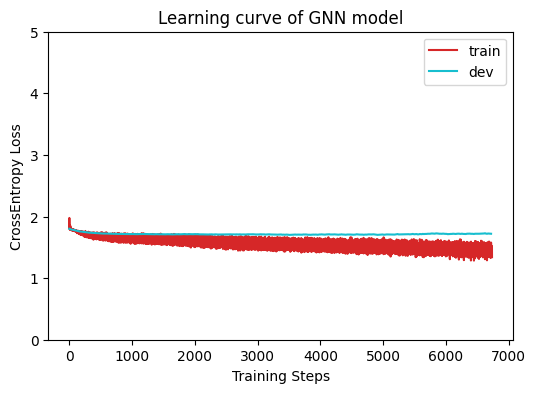

Accuracy = 27.9383%
f1_micro score for each class: [0.2625     0.39655172 0.22377622 0.24858757 0.17054264 0.29441624]
f1_micro score average: 0.27

2 iteration
Saving model (epoch =    1, loss = 1.8037, accuracy = 17.9537%)
Saving model (epoch =    2, loss = 1.7958, accuracy = 14.8649%)
Saving model (epoch =    3, loss = 1.7956, accuracy = 17.5676%)
Saving model (epoch =    4, loss = 1.7935, accuracy = 16.6023%)
Saving model (epoch =    5, loss = 1.7920, accuracy = 16.7954%)
Saving model (epoch =    6, loss = 1.7879, accuracy = 17.7606%)
Saving model (epoch =    7, loss = 1.7830, accuracy = 19.6911%)
Saving model (epoch =    8, loss = 1.7762, accuracy = 19.4981%)
Saving model (epoch =    9, loss = 1.7686, accuracy = 18.9189%)
Saving model (epoch =   10, loss = 1.7613, accuracy = 21.6216%)
Saving model (epoch =   11, loss = 1.7550, accuracy = 22.3938%)
Saving model (epoch =   12, loss = 1.7492, accuracy = 23.7452%)
Saving model (epoch =   13, loss = 1.7442, accuracy = 23.7452%)
Saving 

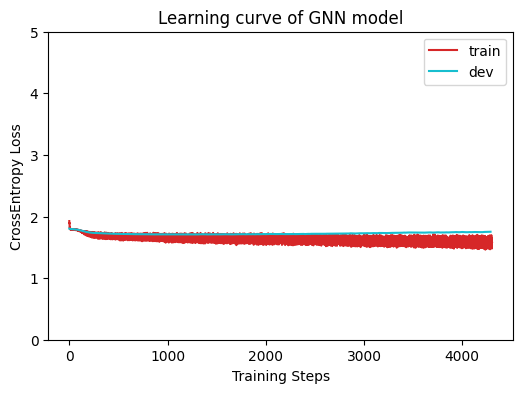

Accuracy = 32.5626%
f1_micro score for each class: [0.30167598 0.47926267 0.23357664 0.35802469 0.23391813 0.29069767]
f1_micro score average: 0.32

3 iteration
Saving model (epoch =    1, loss = 1.8086, accuracy = 16.9557%)
Saving model (epoch =    2, loss = 1.8046, accuracy = 17.1484%)
Saving model (epoch =    3, loss = 1.7997, accuracy = 16.5703%)
Saving model (epoch =    4, loss = 1.7957, accuracy = 18.1118%)
Saving model (epoch =    5, loss = 1.7918, accuracy = 19.4605%)
Saving model (epoch =    6, loss = 1.7873, accuracy = 19.8459%)
Saving model (epoch =    7, loss = 1.7815, accuracy = 19.0751%)
Saving model (epoch =    8, loss = 1.7757, accuracy = 20.6166%)
Saving model (epoch =    9, loss = 1.7685, accuracy = 21.5800%)
Saving model (epoch =   10, loss = 1.7613, accuracy = 21.7726%)
Saving model (epoch =   11, loss = 1.7526, accuracy = 22.5434%)
Saving model (epoch =   12, loss = 1.7463, accuracy = 24.0848%)
Saving model (epoch =   13, loss = 1.7402, accuracy = 23.6994%)
Saving 

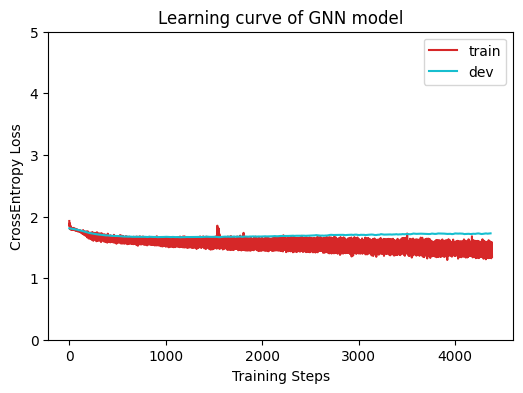

Accuracy = 32.3699%
f1_micro score for each class: [0.14705882 0.53389831 0.29007634 0.30769231 0.23655914 0.31088083]
f1_micro score average: 0.30

4 iteration
Saving model (epoch =    1, loss = 1.8162, accuracy = 15.7996%)
Saving model (epoch =    2, loss = 1.8080, accuracy = 17.5337%)
Saving model (epoch =    3, loss = 1.8014, accuracy = 15.6069%)
Saving model (epoch =    4, loss = 1.7976, accuracy = 16.9557%)
Saving model (epoch =    5, loss = 1.7959, accuracy = 16.9557%)
Saving model (epoch =    6, loss = 1.7938, accuracy = 17.7264%)
Saving model (epoch =    7, loss = 1.7912, accuracy = 18.8825%)
Saving model (epoch =    8, loss = 1.7891, accuracy = 18.4971%)
Saving model (epoch =    9, loss = 1.7859, accuracy = 20.4239%)
Saving model (epoch =   10, loss = 1.7834, accuracy = 20.8092%)
Saving model (epoch =   11, loss = 1.7789, accuracy = 21.0019%)
Saving model (epoch =   12, loss = 1.7745, accuracy = 21.3873%)
Saving model (epoch =   13, loss = 1.7705, accuracy = 21.5800%)
Saving 

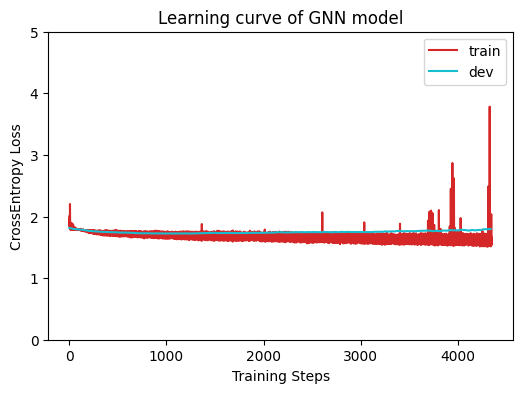

Accuracy = 23.5067%
f1_micro score for each class: [0.17857143 0.38317757 0.21118012 0.2        0.23589744 0.14666667]
f1_micro score average: 0.23

5 iteration
Saving model (epoch =    1, loss = 1.8085, accuracy = 18.3398%)
Saving model (epoch =    2, loss = 1.8008, accuracy = 16.6023%)
Saving model (epoch =    3, loss = 1.7979, accuracy = 18.7259%)
Saving model (epoch =    4, loss = 1.7968, accuracy = 18.5328%)
Saving model (epoch =    5, loss = 1.7955, accuracy = 19.3050%)
Saving model (epoch =    6, loss = 1.7916, accuracy = 19.1120%)
Saving model (epoch =    7, loss = 1.7881, accuracy = 20.2703%)
Saving model (epoch =    8, loss = 1.7838, accuracy = 21.4286%)
Saving model (epoch =    9, loss = 1.7778, accuracy = 23.9382%)
Saving model (epoch =   10, loss = 1.7712, accuracy = 24.3243%)
Saving model (epoch =   11, loss = 1.7643, accuracy = 24.9035%)
Saving model (epoch =   12, loss = 1.7558, accuracy = 26.2548%)
Saving model (epoch =   13, loss = 1.7495, accuracy = 26.6409%)
Saving 

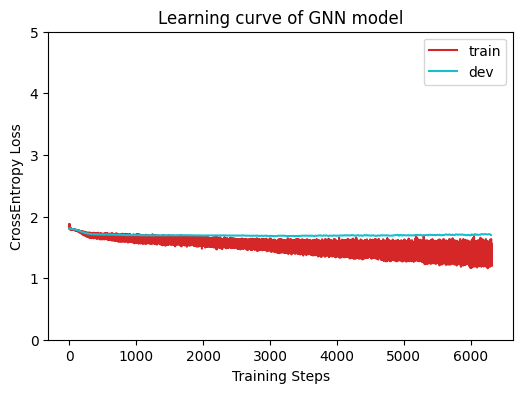

Accuracy = 28.3237%
f1_micro score for each class: [0.24277457 0.45882353 0.15068493 0.24806202 0.25906736 0.30837004]
f1_micro score average: 0.28

6 iteration
Saving model (epoch =    1, loss = 1.7967, accuracy = 18.1118%)
Saving model (epoch =    2, loss = 1.7878, accuracy = 18.1118%)
Saving model (epoch =    3, loss = 1.7841, accuracy = 18.8825%)
Saving model (epoch =    4, loss = 1.7762, accuracy = 20.6166%)
Saving model (epoch =    5, loss = 1.7673, accuracy = 21.5800%)
Saving model (epoch =    6, loss = 1.7545, accuracy = 23.5067%)
Saving model (epoch =    7, loss = 1.7426, accuracy = 23.3141%)
Saving model (epoch =    8, loss = 1.7301, accuracy = 24.0848%)
Saving model (epoch =    9, loss = 1.7195, accuracy = 24.8555%)
Saving model (epoch =   10, loss = 1.7130, accuracy = 25.0482%)
Saving model (epoch =   11, loss = 1.7064, accuracy = 25.4335%)
Saving model (epoch =   12, loss = 1.7013, accuracy = 25.4335%)
Saving model (epoch =   13, loss = 1.6979, accuracy = 25.8189%)
Saving 

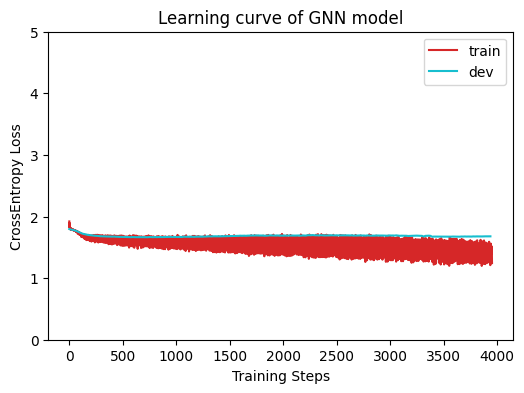

Accuracy = 28.9017%
f1_micro score for each class: [0.17054264 0.58762887 0.21621622 0.22360248 0.28220859 0.1025641 ]
f1_micro score average: 0.26

7 iteration
Saving model (epoch =    1, loss = 1.8067, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.7950, accuracy = 20.4239%)
Saving model (epoch =    3, loss = 1.7877, accuracy = 20.8092%)
Saving model (epoch =    4, loss = 1.7808, accuracy = 20.8092%)
Saving model (epoch =    5, loss = 1.7730, accuracy = 23.5067%)
Saving model (epoch =    6, loss = 1.7632, accuracy = 25.6262%)
Saving model (epoch =    7, loss = 1.7513, accuracy = 25.2408%)
Saving model (epoch =    8, loss = 1.7391, accuracy = 26.2042%)
Saving model (epoch =    9, loss = 1.7264, accuracy = 28.1310%)
Saving model (epoch =   10, loss = 1.7152, accuracy = 28.3237%)
Saving model (epoch =   11, loss = 1.7049, accuracy = 27.9383%)
Saving model (epoch =   12, loss = 1.6954, accuracy = 29.0944%)
Saving model (epoch =   13, loss = 1.6884, accuracy = 29.2871%)
Saving 

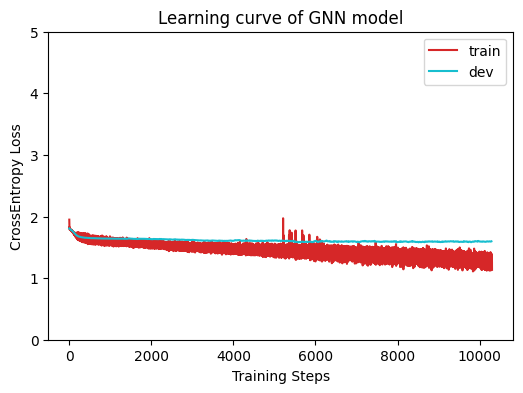

Accuracy = 36.6089%
f1_micro score for each class: [0.34682081 0.47533632 0.36942675 0.3908046  0.23357664 0.32183908]
f1_micro score average: 0.36

8 iteration
Saving model (epoch =    1, loss = 1.8251, accuracy = 15.0579%)
Saving model (epoch =    2, loss = 1.8057, accuracy = 14.2857%)
Saving model (epoch =    5, loss = 1.8046, accuracy = 15.2510%)
Saving model (epoch =    6, loss = 1.8016, accuracy = 14.8649%)
Saving model (epoch =    7, loss = 1.7991, accuracy = 15.0579%)
Saving model (epoch =    8, loss = 1.7959, accuracy = 15.2510%)
Saving model (epoch =    9, loss = 1.7937, accuracy = 16.0232%)
Saving model (epoch =   10, loss = 1.7917, accuracy = 17.7606%)
Saving model (epoch =   11, loss = 1.7885, accuracy = 17.1815%)
Saving model (epoch =   12, loss = 1.7856, accuracy = 17.7606%)
Saving model (epoch =   13, loss = 1.7820, accuracy = 17.9537%)
Saving model (epoch =   14, loss = 1.7790, accuracy = 19.1120%)
Saving model (epoch =   15, loss = 1.7767, accuracy = 18.9189%)
Saving 

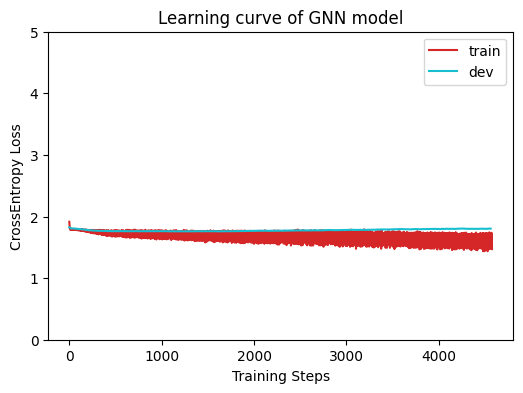

Accuracy = 26.0116%
f1_micro score for each class: [0.144      0.42741935 0.19736842 0.25730994 0.24096386 0.18181818]
f1_micro score average: 0.24

9 iteration
Saving model (epoch =    1, loss = 1.8088, accuracy = 16.6023%)
Saving model (epoch =    2, loss = 1.8030, accuracy = 15.8301%)
Saving model (epoch =    3, loss = 1.8006, accuracy = 16.7954%)
Saving model (epoch =    4, loss = 1.7959, accuracy = 17.1815%)
Saving model (epoch =    5, loss = 1.7938, accuracy = 17.3745%)
Saving model (epoch =    6, loss = 1.7900, accuracy = 18.1467%)
Saving model (epoch =    7, loss = 1.7859, accuracy = 19.4981%)
Saving model (epoch =    8, loss = 1.7793, accuracy = 21.6216%)
Saving model (epoch =    9, loss = 1.7688, accuracy = 25.8687%)
Saving model (epoch =   10, loss = 1.7558, accuracy = 28.7645%)
Saving model (epoch =   11, loss = 1.7395, accuracy = 29.5367%)
Saving model (epoch =   12, loss = 1.7237, accuracy = 29.9228%)
Saving model (epoch =   13, loss = 1.7113, accuracy = 30.1158%)
Saving 

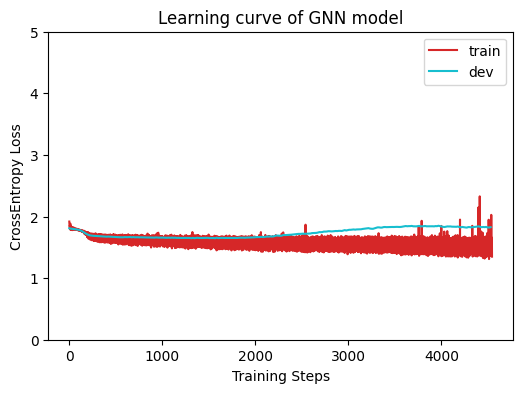

Accuracy = 31.9846%
f1_micro score for each class: [0.04081633 0.52023121 0.05825243 0.45454545 0.3277592  0.28571429]
f1_micro score average: 0.28

10 iteration
Saving model (epoch =    1, loss = 1.8177, accuracy = 16.4093%)
Saving model (epoch =    2, loss = 1.8063, accuracy = 17.9537%)
Saving model (epoch =    3, loss = 1.8047, accuracy = 16.9884%)
Saving model (epoch =    4, loss = 1.8045, accuracy = 17.9537%)
Saving model (epoch =    5, loss = 1.8012, accuracy = 18.3398%)
Saving model (epoch =    6, loss = 1.7997, accuracy = 18.5328%)
Saving model (epoch =    7, loss = 1.7981, accuracy = 18.7259%)
Saving model (epoch =    8, loss = 1.7961, accuracy = 18.9189%)
Saving model (epoch =    9, loss = 1.7948, accuracy = 18.5328%)
Saving model (epoch =   10, loss = 1.7933, accuracy = 18.7259%)
Saving model (epoch =   11, loss = 1.7906, accuracy = 19.6911%)
Saving model (epoch =   12, loss = 1.7899, accuracy = 20.2703%)
Saving model (epoch =   13, loss = 1.7889, accuracy = 20.2703%)
Saving

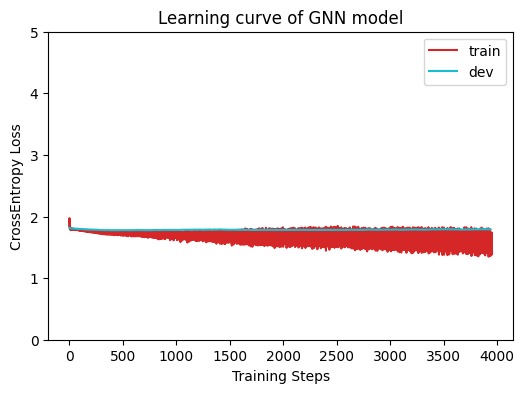

Accuracy = 23.8921%
f1_micro score for each class: [0.17857143 0.31111111 0.11111111 0.23255814 0.30604982 0.18604651]
f1_micro score average: 0.22
Final accuracy for each dataset: [0.279383429672447, 0.325626204238921, 0.3236994219653179, 0.2350674373795761, 0.2832369942196532, 0.28901734104046245, 0.36608863198458574, 0.26011560693641617, 0.3198458574181118, 0.23892100192678228]
Average accuracy: 29.2100%


In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 10**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

GAT(
  (initial_conv): GATv2Conv(32, 3, heads=8)
  (conv1): GATv2Conv(24, 3, heads=8)
  (conv2): GATv2Conv(24, 3, heads=8)
  (conv3): GATv2Conv(24, 3, heads=8)
  (set2set): Set2Set(24, 48)
  (sagpool): SAGPooling(GATv2Conv, 24, ratio=0.75, multiplier=1.0)
  (out): Linear(in_features=48, out_features=6, bias=True)
  (criterion): CrossEntropyLoss()
)
Number of parameters:  12827

1 iteration
Saving model (epoch =    1, loss = 1.7993, accuracy = 18.8825%)
Saving model (epoch =    2, loss = 1.7921, accuracy = 18.6898%)
Saving model (epoch =    3, loss = 1.7886, accuracy = 18.8825%)
Saving model (epoch =    4, loss = 1.7866, accuracy = 18.3044%)
Saving model (epoch =    5, loss = 1.7827, accuracy = 19.6532%)
Saving model (epoch =    6, loss = 1.7777, accuracy = 22.3507%)
Saving model (epoch =    7, loss = 1.7725, accuracy = 22.9287%)
Saving model (epoch =    8, loss = 1.7675, accuracy = 23.3141%)
Saving model (epoch =    9, loss = 1.7627, accuracy = 24.0848%)
Saving model (epoch =   10, los

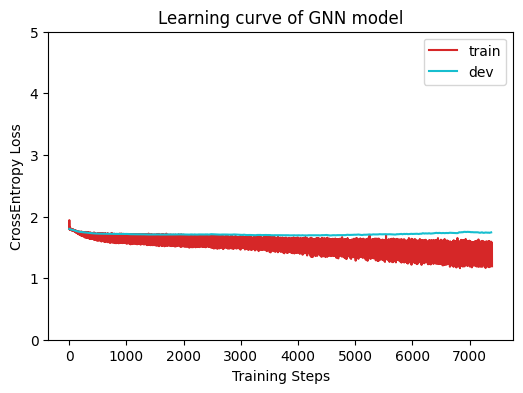

Accuracy = 28.7091%
f1_micro score for each class: [0.29447853 0.45833333 0.1971831  0.26086957 0.12865497 0.29813665]
f1_micro score average: 0.27

2 iteration
Saving model (epoch =    1, loss = 1.7997, accuracy = 17.9537%)
Saving model (epoch =    2, loss = 1.7937, accuracy = 15.6371%)
Saving model (epoch =    3, loss = 1.7925, accuracy = 17.1815%)
Saving model (epoch =    4, loss = 1.7908, accuracy = 16.7954%)
Saving model (epoch =    5, loss = 1.7875, accuracy = 18.1467%)
Saving model (epoch =    6, loss = 1.7831, accuracy = 19.1120%)
Saving model (epoch =    7, loss = 1.7780, accuracy = 19.4981%)
Saving model (epoch =    8, loss = 1.7716, accuracy = 19.6911%)
Saving model (epoch =    9, loss = 1.7656, accuracy = 21.4286%)
Saving model (epoch =   10, loss = 1.7592, accuracy = 23.5521%)
Saving model (epoch =   11, loss = 1.7544, accuracy = 23.5521%)
Saving model (epoch =   12, loss = 1.7496, accuracy = 23.5521%)
Saving model (epoch =   13, loss = 1.7462, accuracy = 24.7104%)
Saving 

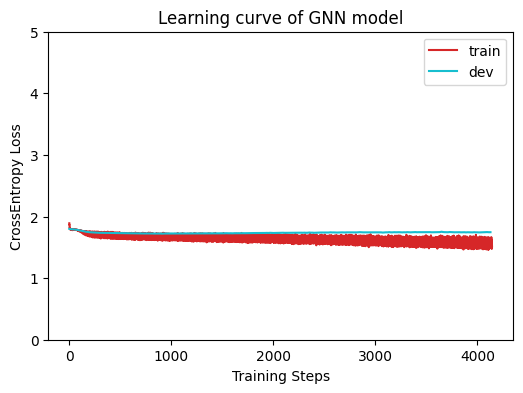

Accuracy = 28.9017%
f1_micro score for each class: [0.25609756 0.4        0.26666667 0.28776978 0.21052632 0.29714286]
f1_micro score average: 0.29

3 iteration
Saving model (epoch =    1, loss = 1.8052, accuracy = 17.1484%)
Saving model (epoch =    2, loss = 1.7990, accuracy = 17.7264%)
Saving model (epoch =    3, loss = 1.7946, accuracy = 17.5337%)
Saving model (epoch =    4, loss = 1.7924, accuracy = 17.9191%)
Saving model (epoch =    5, loss = 1.7885, accuracy = 19.4605%)
Saving model (epoch =    6, loss = 1.7836, accuracy = 19.4605%)
Saving model (epoch =    7, loss = 1.7769, accuracy = 21.1946%)
Saving model (epoch =    8, loss = 1.7699, accuracy = 21.7726%)
Saving model (epoch =    9, loss = 1.7610, accuracy = 22.7360%)
Saving model (epoch =   10, loss = 1.7524, accuracy = 24.2775%)
Saving model (epoch =   11, loss = 1.7437, accuracy = 24.2775%)
Saving model (epoch =   12, loss = 1.7361, accuracy = 25.0482%)
Saving model (epoch =   13, loss = 1.7291, accuracy = 25.0482%)
Saving 

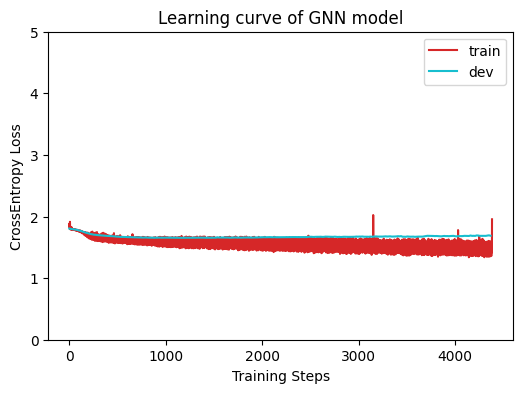

Accuracy = 30.0578%
f1_micro score for each class: [0.2        0.52054795 0.28368794 0.27710843 0.23350254 0.21714286]
f1_micro score average: 0.29

4 iteration
Saving model (epoch =    1, loss = 1.8160, accuracy = 15.7996%)
Saving model (epoch =    2, loss = 1.8054, accuracy = 18.6898%)
Saving model (epoch =    3, loss = 1.7997, accuracy = 17.3410%)
Saving model (epoch =    4, loss = 1.7970, accuracy = 17.3410%)
Saving model (epoch =    5, loss = 1.7949, accuracy = 17.3410%)
Saving model (epoch =    6, loss = 1.7931, accuracy = 17.1484%)
Saving model (epoch =    7, loss = 1.7911, accuracy = 17.9191%)
Saving model (epoch =    8, loss = 1.7891, accuracy = 18.4971%)
Saving model (epoch =    9, loss = 1.7873, accuracy = 19.6532%)
Saving model (epoch =   10, loss = 1.7846, accuracy = 21.1946%)
Saving model (epoch =   11, loss = 1.7820, accuracy = 20.4239%)
Saving model (epoch =   12, loss = 1.7785, accuracy = 22.1580%)
Saving model (epoch =   13, loss = 1.7747, accuracy = 22.5434%)
Saving 

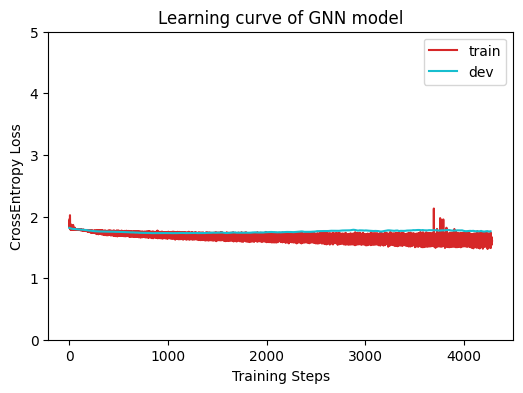

Accuracy = 22.7360%
f1_micro score for each class: [0.13253012 0.37885463 0.20779221 0.23684211 0.20779221 0.15135135]
f1_micro score average: 0.22

5 iteration
Saving model (epoch =    1, loss = 1.8062, accuracy = 18.3398%)
Saving model (epoch =    2, loss = 1.7972, accuracy = 16.9884%)
Saving model (epoch =    3, loss = 1.7958, accuracy = 18.9189%)
Saving model (epoch =    4, loss = 1.7931, accuracy = 19.3050%)
Saving model (epoch =    5, loss = 1.7907, accuracy = 19.3050%)
Saving model (epoch =    6, loss = 1.7863, accuracy = 19.8842%)
Saving model (epoch =    7, loss = 1.7809, accuracy = 22.3938%)
Saving model (epoch =    8, loss = 1.7741, accuracy = 24.3243%)
Saving model (epoch =    9, loss = 1.7670, accuracy = 24.7104%)
Saving model (epoch =   10, loss = 1.7612, accuracy = 24.5174%)
Saving model (epoch =   11, loss = 1.7546, accuracy = 25.2896%)
Saving model (epoch =   12, loss = 1.7477, accuracy = 26.4479%)
Saving model (epoch =   13, loss = 1.7413, accuracy = 27.0270%)
Saving 

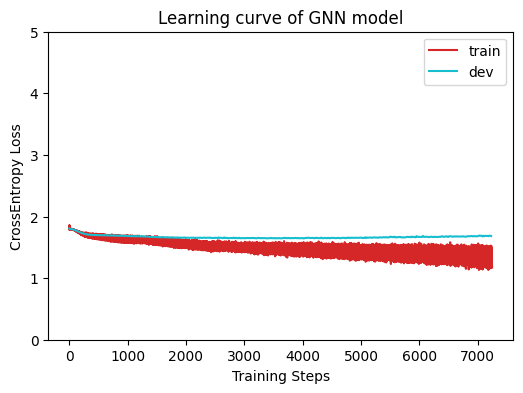

Accuracy = 30.8285%
f1_micro score for each class: [0.2189781  0.46788991 0.10687023 0.29166667 0.28125    0.36111111]
f1_micro score average: 0.29

6 iteration
Saving model (epoch =    1, loss = 1.7936, accuracy = 18.3044%)
Saving model (epoch =    2, loss = 1.7863, accuracy = 18.4971%)
Saving model (epoch =    3, loss = 1.7823, accuracy = 19.0751%)
Saving model (epoch =    4, loss = 1.7761, accuracy = 21.0019%)
Saving model (epoch =    5, loss = 1.7685, accuracy = 22.5434%)
Saving model (epoch =    6, loss = 1.7591, accuracy = 23.5067%)
Saving model (epoch =    7, loss = 1.7492, accuracy = 25.8189%)
Saving model (epoch =    8, loss = 1.7372, accuracy = 25.6262%)
Saving model (epoch =    9, loss = 1.7262, accuracy = 25.6262%)
Saving model (epoch =   10, loss = 1.7168, accuracy = 26.0116%)
Saving model (epoch =   11, loss = 1.7092, accuracy = 25.8189%)
Saving model (epoch =   12, loss = 1.7032, accuracy = 26.2042%)
Saving model (epoch =   13, loss = 1.6988, accuracy = 26.3969%)
Saving 

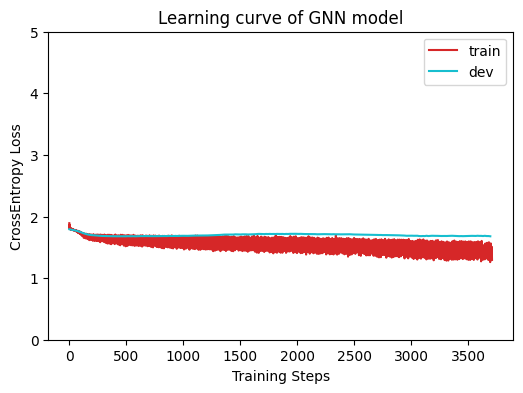

Accuracy = 29.2871%
f1_micro score for each class: [0.20588235 0.58163265 0.26229508 0.23287671 0.26380368 0.08928571]
f1_micro score average: 0.27

7 iteration
Saving model (epoch =    1, loss = 1.8034, accuracy = 18.6898%)
Saving model (epoch =    2, loss = 1.7922, accuracy = 19.6532%)
Saving model (epoch =    3, loss = 1.7870, accuracy = 21.3873%)
Saving model (epoch =    4, loss = 1.7801, accuracy = 21.7726%)
Saving model (epoch =    5, loss = 1.7714, accuracy = 23.5067%)
Saving model (epoch =    6, loss = 1.7607, accuracy = 26.5896%)
Saving model (epoch =    7, loss = 1.7485, accuracy = 26.7823%)
Saving model (epoch =    8, loss = 1.7369, accuracy = 27.3603%)
Saving model (epoch =    9, loss = 1.7253, accuracy = 27.3603%)
Saving model (epoch =   10, loss = 1.7139, accuracy = 27.7457%)
Saving model (epoch =   11, loss = 1.7040, accuracy = 28.3237%)
Saving model (epoch =   12, loss = 1.6958, accuracy = 28.5164%)
Saving model (epoch =   13, loss = 1.6886, accuracy = 29.6724%)
Saving 

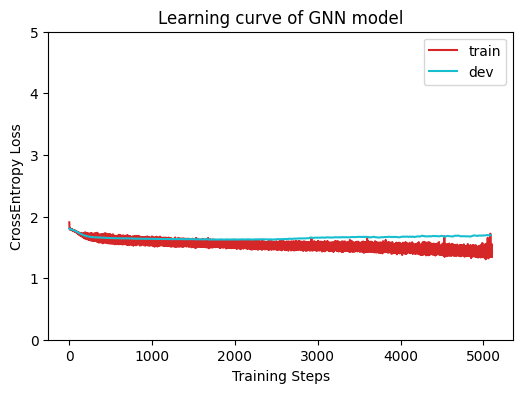

Accuracy = 32.9480%
f1_micro score for each class: [0.28735632 0.44843049 0.40425532 0.27272727 0.2987013  0.19310345]
f1_micro score average: 0.32

8 iteration
Saving model (epoch =    1, loss = 1.8218, accuracy = 15.0579%)
Saving model (epoch =    2, loss = 1.8015, accuracy = 14.6718%)
Saving model (epoch =    5, loss = 1.7996, accuracy = 15.2510%)
Saving model (epoch =    6, loss = 1.7974, accuracy = 15.8301%)
Saving model (epoch =    7, loss = 1.7954, accuracy = 15.6371%)
Saving model (epoch =    8, loss = 1.7932, accuracy = 16.7954%)
Saving model (epoch =    9, loss = 1.7902, accuracy = 17.7606%)
Saving model (epoch =   10, loss = 1.7866, accuracy = 17.7606%)
Saving model (epoch =   11, loss = 1.7836, accuracy = 17.7606%)
Saving model (epoch =   12, loss = 1.7794, accuracy = 18.9189%)
Saving model (epoch =   13, loss = 1.7758, accuracy = 18.3398%)
Saving model (epoch =   14, loss = 1.7723, accuracy = 19.1120%)
Saving model (epoch =   15, loss = 1.7686, accuracy = 19.8842%)
Saving 

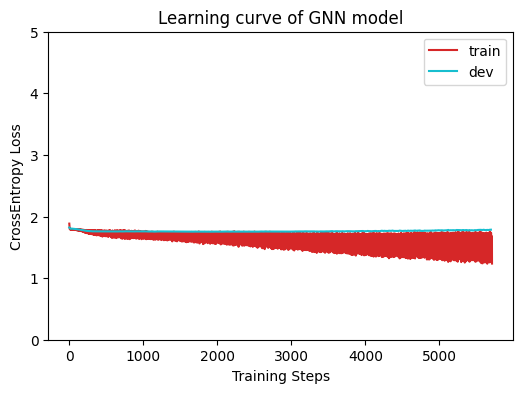

Accuracy = 24.4701%
f1_micro score for each class: [0.10958904 0.4063745  0.22516556 0.19354839 0.22058824 0.21105528]
f1_micro score average: 0.23

9 iteration
Saving model (epoch =    1, loss = 1.8045, accuracy = 16.6023%)
Saving model (epoch =    2, loss = 1.7984, accuracy = 16.2162%)
Saving model (epoch =    3, loss = 1.7966, accuracy = 16.7954%)
Saving model (epoch =    4, loss = 1.7943, accuracy = 17.3745%)
Saving model (epoch =    5, loss = 1.7929, accuracy = 17.5676%)
Saving model (epoch =    6, loss = 1.7905, accuracy = 17.1815%)
Saving model (epoch =    7, loss = 1.7861, accuracy = 18.5328%)
Saving model (epoch =    8, loss = 1.7815, accuracy = 21.4286%)
Saving model (epoch =    9, loss = 1.7742, accuracy = 24.3243%)
Saving model (epoch =   10, loss = 1.7639, accuracy = 27.2201%)
Saving model (epoch =   11, loss = 1.7523, accuracy = 28.1853%)
Saving model (epoch =   12, loss = 1.7362, accuracy = 29.3436%)
Saving model (epoch =   13, loss = 1.7221, accuracy = 30.1158%)
Saving 

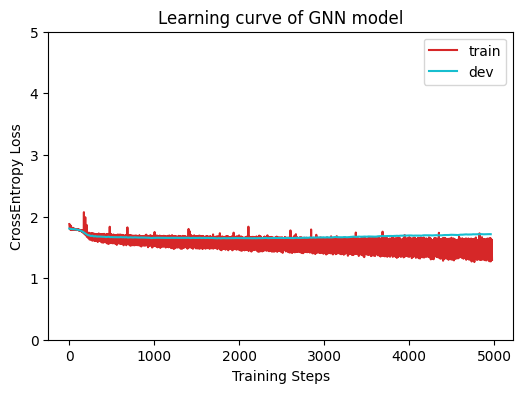

Accuracy = 31.9846%
f1_micro score for each class: [0.12173913 0.52023121 0.09433962 0.41573034 0.3197026  0.29441624]
f1_micro score average: 0.29

10 iteration
Saving model (epoch =    1, loss = 1.8130, accuracy = 16.4093%)
Saving model (epoch =    2, loss = 1.8015, accuracy = 17.9537%)
Saving model (epoch =    3, loss = 1.8000, accuracy = 17.1815%)
Saving model (epoch =    4, loss = 1.7993, accuracy = 17.3745%)
Saving model (epoch =    5, loss = 1.7982, accuracy = 18.3398%)
Saving model (epoch =    6, loss = 1.7950, accuracy = 18.7259%)
Saving model (epoch =    7, loss = 1.7931, accuracy = 18.9189%)
Saving model (epoch =    8, loss = 1.7912, accuracy = 19.3050%)
Saving model (epoch =    9, loss = 1.7896, accuracy = 19.4981%)
Saving model (epoch =   10, loss = 1.7882, accuracy = 19.4981%)
Saving model (epoch =   11, loss = 1.7867, accuracy = 19.8842%)
Saving model (epoch =   12, loss = 1.7856, accuracy = 20.0772%)
Saving model (epoch =   13, loss = 1.7847, accuracy = 20.6564%)
Saving

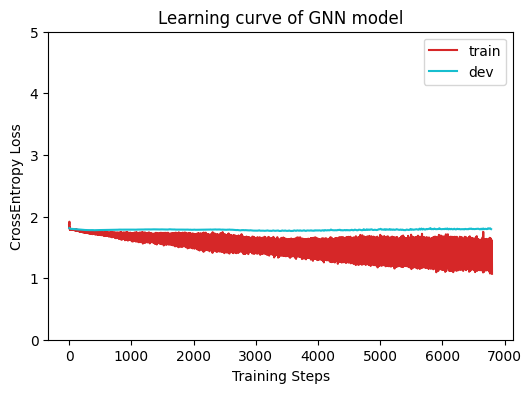

Accuracy = 25.6262%
f1_micro score for each class: [0.19354839 0.46153846 0.12345679 0.24719101 0.24444444 0.15503876]
f1_micro score average: 0.24
Final accuracy for each dataset: [0.28709055876685935, 0.28901734104046245, 0.30057803468208094, 0.22736030828516376, 0.30828516377649323, 0.2928709055876686, 0.32947976878612717, 0.24470134874759153, 0.3198458574181118, 0.25626204238921]
Average accuracy: 28.5549%


In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'pearson'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

### **Euclidean**

#### **k = 3**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 6**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 10**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'euclidean'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

### **Cosine**

#### **k = 3**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 3
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 6**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 6
average_test(Model, hparas, data_config, config, device, myseed)

#### **k = 10**

In [ ]:
Model = GCN
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GAT
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)

In [ ]:
Model = GraphSAGE
hparas = {}
data_config['edge_mode'] = 'cosine'
data_config['k-neighbor'] = 10
average_test(Model, hparas, data_config, config, device, myseed)